# GWP 2

## Step 1

In this GWP we will build a Deep Learning model that tries to predict
short-term market trends across different asset classes.

Importing necessary libraries

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import skew, kurtosis, norm, probplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
import tensorflow as tf
from keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.preprocessing import MinMaxScaler
from keras import Sequential
from keras.callbacks import EarlyStopping


First we will download Data of 5 different ETf's SPY, TLT, SHY, GLD, DBO from January 1st, 2018 to December 30th, 2022.

In [2]:
## Download Data for ETFs
etfs = ["SPY", "TLT", "SHY", "GLD", "DBO"]
start_date = "2018-01-01"
end_date = "2022-12-30"

# Download data
data = {etf: yf.download(etf, start=start_date, end=end_date)['Close'] for etf in etfs}

# Align all valid data to the same index
aligned_data = pd.concat(data.values(), axis=1)

# Drop rows with missing data (if any)
close_prices = aligned_data.dropna()

# Convert the Date index to datetime format without time
close_prices.index = pd.to_datetime(close_prices.index).date

# Display the first few rows of the DataFrame
print("Successfully created DataFrame for valid ETFs with aligned dates.")
print(close_prices.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Successfully created DataFrame for valid ETFs with aligned dates.
Ticker             SPY         TLT        SHY         GLD    DBO
2018-01-02  268.769989  125.489998  83.820000  125.150002  10.19
2018-01-03  270.470001  126.089996  83.820000  124.820000  10.41
2018-01-04  271.609985  126.070000  83.779999  125.459999  10.43
2018-01-05  273.420013  125.709999  83.779999  125.330002  10.38
2018-01-08  273.920013  125.629997  83.779999  125.309998  10.44


In [3]:
close_prices.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1258 entries, 2018-01-02 to 2022-12-29
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SPY     1258 non-null   float64
 1   TLT     1258 non-null   float64
 2   SHY     1258 non-null   float64
 3   GLD     1258 non-null   float64
 4   DBO     1258 non-null   float64
dtypes: float64(5)
memory usage: 59.0+ KB


Now we will start our EDA, we will see some descriptive statistics of the dataset then we will find the return and plot it.

In [4]:
# Save data for reproducibility
close_prices.to_csv("etf_close_prices.csv")

# Step 1b: Exploratory Data Analysis
# 1. Summary Statistics
summary_stats = close_prices.describe()
print("Summary Statistics:\n", summary_stats)


Summary Statistics:
 Ticker          SPY          TLT          SHY          GLD          DBO
count   1258.000000  1258.000000  1258.000000  1258.000000  1258.000000
mean     344.308625   134.630079    84.553426   150.921431    11.588172
std       66.613497    18.284340     1.595424    22.501465     3.341802
min      222.949997    92.400002    80.589996   111.099998     5.200000
25%      283.965012   119.635002    83.269997   125.865000     9.530000
50%      326.759995   136.504997    84.620003   159.434998    10.915000
75%      402.577507   148.054996    86.250000   169.345005    13.252500
max      477.709991   171.570007    86.800003   193.889999    21.080000


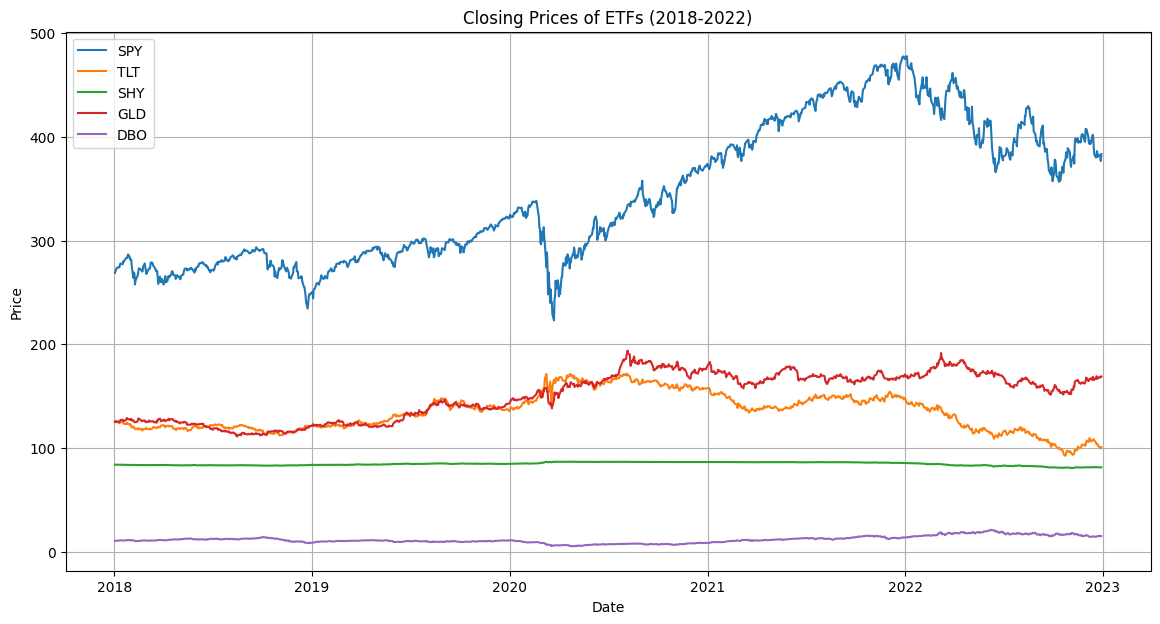

In [5]:
# 2. Daily Returns
daily_returns = close_prices.pct_change().dropna()

# Visualize closing prices
plt.figure(figsize=(14, 7))
for etf in etfs:
    plt.plot(close_prices[etf], label=etf)
plt.title("Closing Prices of ETFs (2018-2022)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid()
plt.show()

Here will visulaize daily return histogram and we will see distribution of our returns.

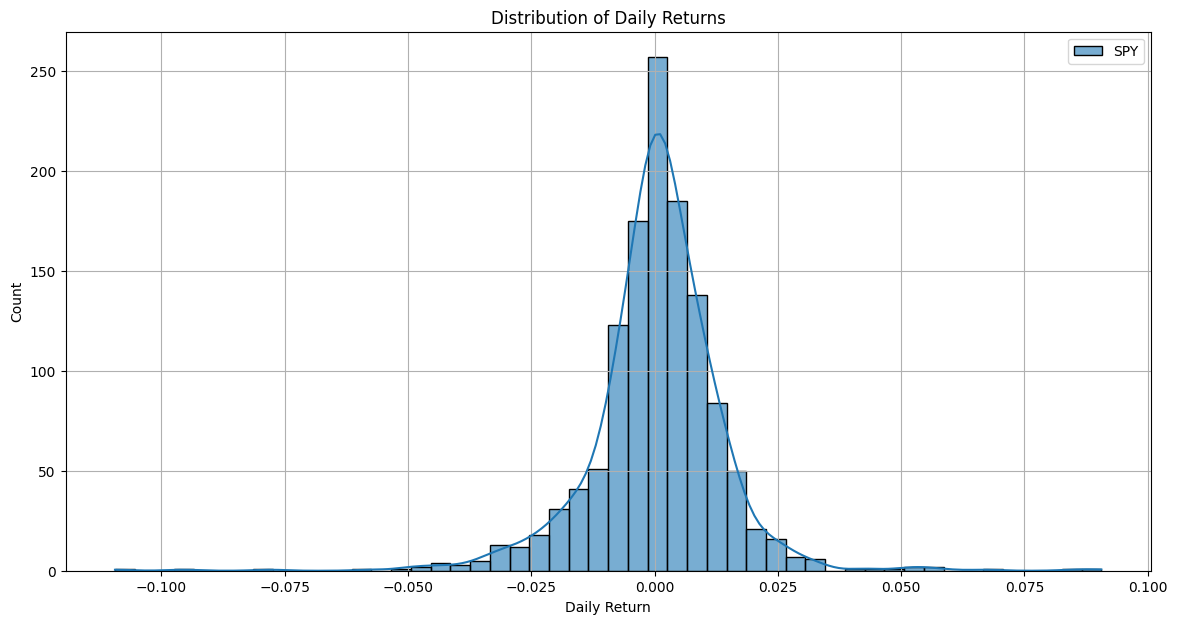

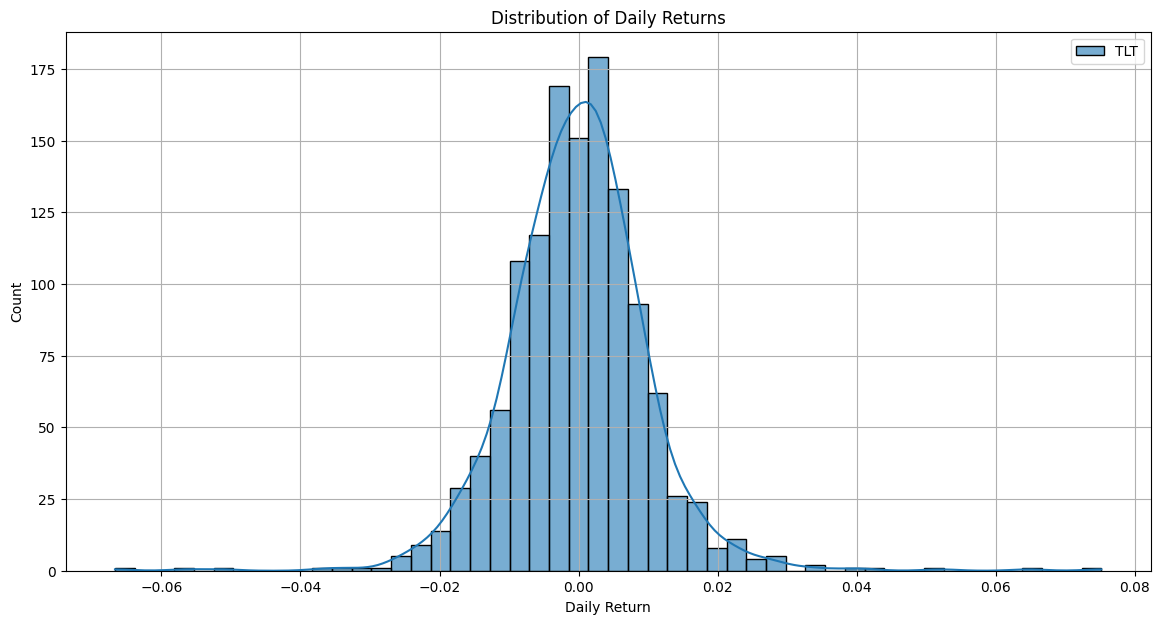

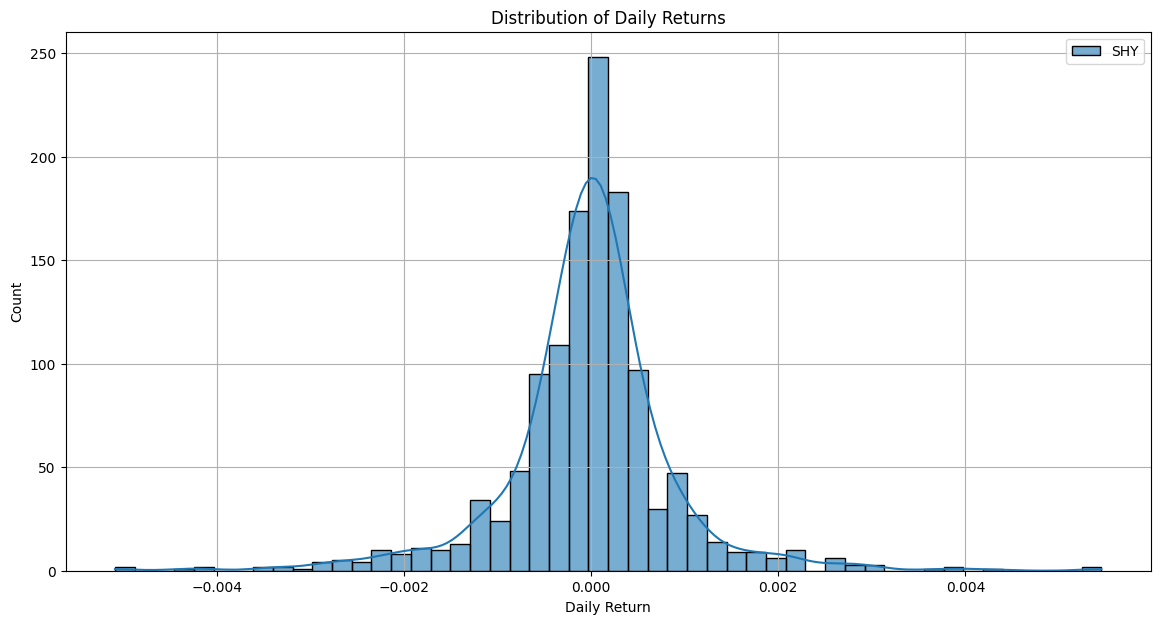

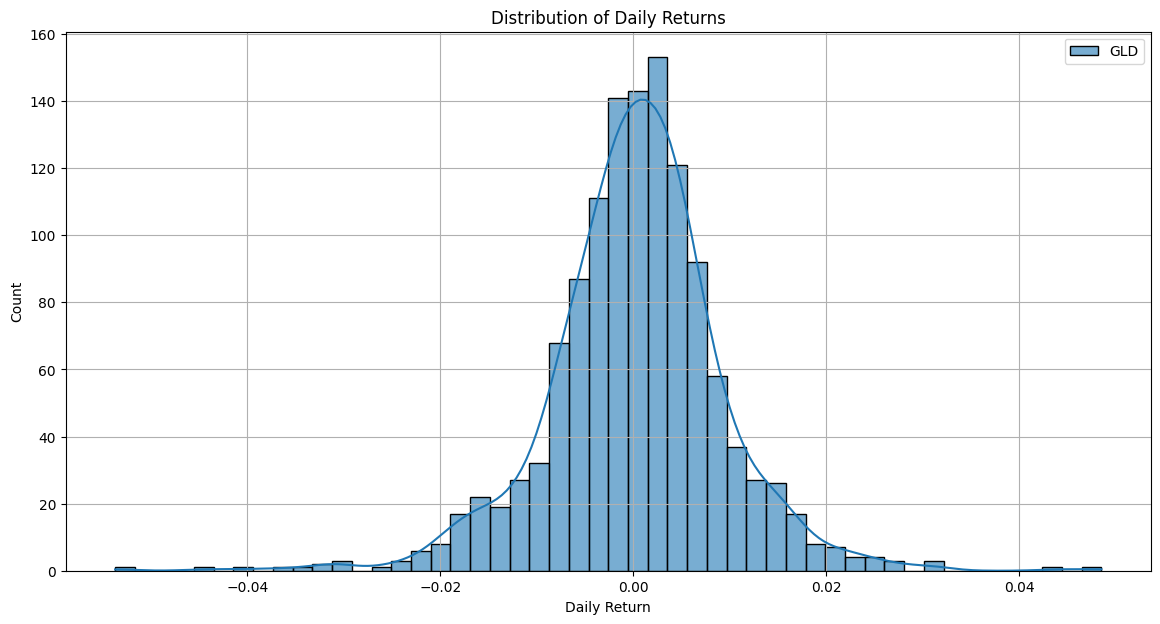

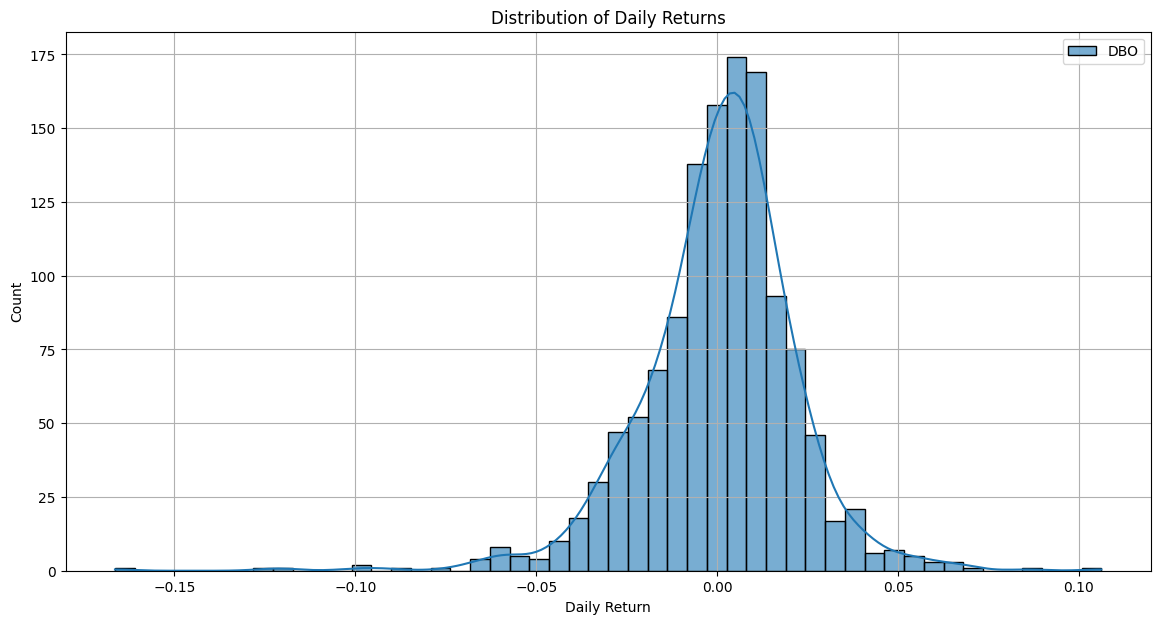

In [6]:
# Visualize daily returns distributions

for etf in etfs:
  plt.figure(figsize=(14, 7))
  sns.histplot(daily_returns[etf], kde=True, label=etf, bins=50, alpha=0.6)
  plt.title("Distribution of Daily Returns")
  plt.xlabel("Daily Return")
  plt.legend()
  plt.grid()
  plt.show()


Here is the correlations matrix of the retruns

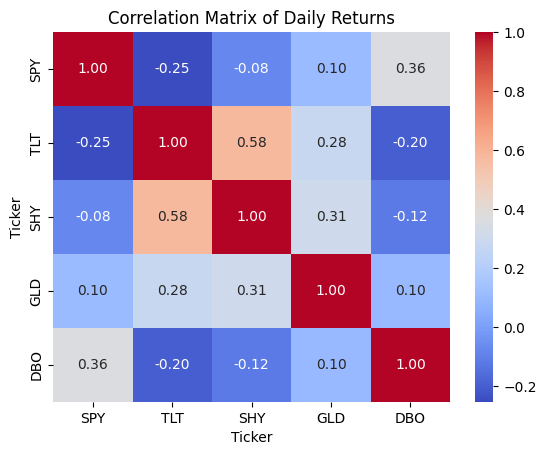

In [7]:
# Correlation Matrix of Returns
correlation_matrix = daily_returns.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Daily Returns")
plt.show()

Now we will do ADF to check for stationarity for our time series dataset.

In [8]:
# Stationarity Test (Augmented Dickey-Fuller)
from statsmodels.tsa.stattools import adfuller

def test_stationarity(series, name):
    result = adfuller(series)
    print(f"ADF Statistic for {name}: {result[0]:.4f}")
    print(f"p-value for {name}: {result[1]:.4f}")

for etf in etfs:
    test_stationarity(close_prices[etf].dropna(), etf)

ADF Statistic for SPY: -1.2506
p-value for SPY: 0.6515
ADF Statistic for TLT: -0.4058
p-value for TLT: 0.9091
ADF Statistic for SHY: -0.0643
p-value for SHY: 0.9529
ADF Statistic for GLD: -1.1950
p-value for GLD: 0.6757
ADF Statistic for DBO: -1.0006
p-value for DBO: 0.7531


Here we can see returns of our etf's are not stationary, so will will move forward to build a stationary dataset.

In [9]:
close_prices

Ticker             SPY         TLT        SHY         GLD    DBO
2018-01-02  268.769989  125.489998  83.820000  125.150002  10.19
2018-01-03  270.470001  126.089996  83.820000  124.820000  10.41
2018-01-04  271.609985  126.070000  83.779999  125.459999  10.43
2018-01-05  273.420013  125.709999  83.779999  125.330002  10.38
2018-01-08  273.920013  125.629997  83.779999  125.309998  10.44
...                ...         ...        ...         ...    ...
2022-12-22  380.720001  103.680000  81.360001  166.759995  14.64
2022-12-23  382.910004  102.160004  81.320000  167.259995  15.00
2022-12-27  381.399994  100.139999  81.209999  168.669998  15.11
2022-12-28  376.660004   99.550003  81.209999  167.910004  14.95
2022-12-29  383.440002  100.680000  81.269997  168.850006  14.88

[1258 rows x 5 columns]

To build a stationary Dataset we will first fins the Log returns of the etf's, you can also see it in plot below.

In [10]:
# Log Returns Transformation for Stationarity
log_returns = np.log(close_prices / close_prices.shift(1)).dropna()

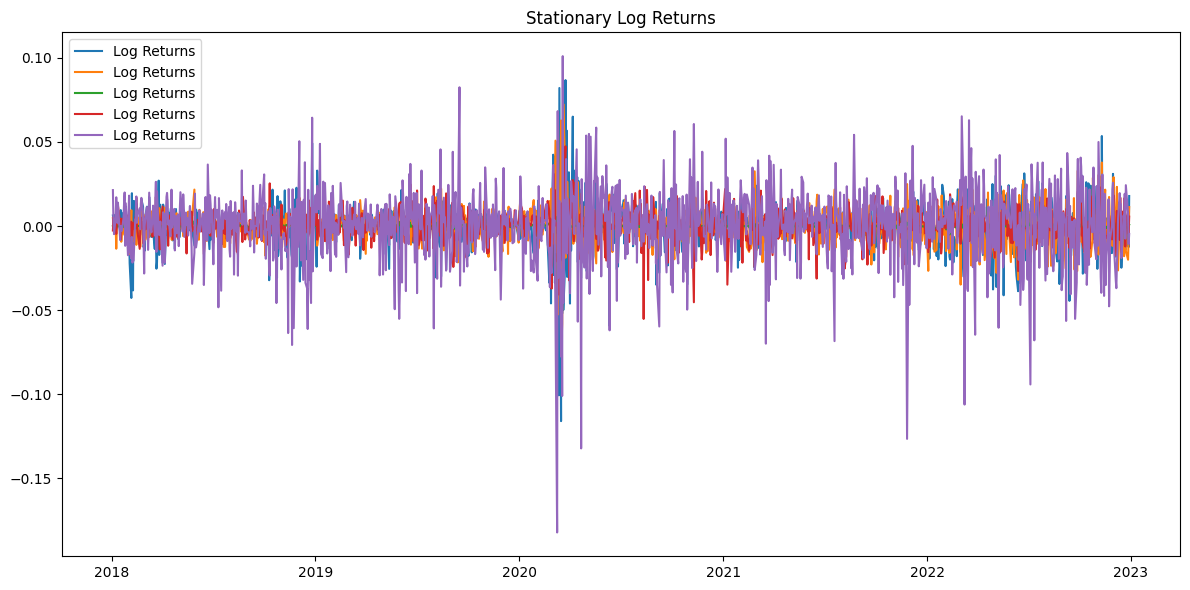

In [11]:
# Plot Transformed Series
plt.figure(figsize=(12, 6))


plt.plot(log_returns, label='Log Returns')
plt.title('Stationary Log Returns')
plt.legend()

plt.tight_layout()
plt.show()

Here is the descriptive statistics summary for all the etf's log return.

In [12]:
# Summary statistics
for etf in etfs:
    print(f"Summary statistics for {etf}:")
    print(log_returns[etf].describe())
    print("\n")



Summary statistics for SPY:
count    1257.000000
mean        0.000283
std         0.013687
min        -0.115887
25%        -0.005266
50%         0.000727
75%         0.007088
max         0.086731
Name: SPY, dtype: float64


Summary statistics for TLT:
count    1257.000000
mean       -0.000175
std         0.010159
min        -0.069010
25%        -0.005884
50%         0.000000
75%         0.005495
max         0.072503
Name: TLT, dtype: float64


Summary statistics for SHY:
count    1257.000000
mean       -0.000025
std         0.000918
min        -0.005101
25%        -0.000354
50%         0.000000
75%         0.000351
max         0.005438
Name: SHY, dtype: float64


Summary statistics for GLD:
count    1257.000000
mean        0.000238
std         0.009057
min        -0.055190
25%        -0.004336
50%         0.000518
75%         0.005080
max         0.047390
Name: GLD, dtype: float64


Summary statistics for DBO:
count    1257.000000
mean        0.000301
std         0.021876
min        -0

Now we will do ACF plots of our return to check for stationarity, and below you guys can see the ACF plots suggest that the data is stationary.

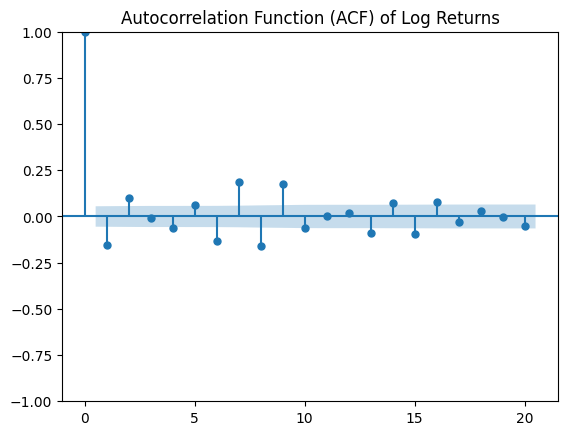

Ljung-Box Test for Autocorrelation (lags=10):
       lb_stat     lb_pvalue
10  195.354275  1.500667e-36


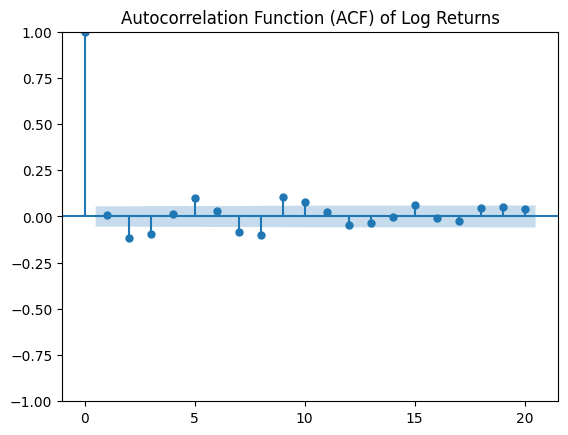

Ljung-Box Test for Autocorrelation (lags=10):
      lb_stat     lb_pvalue
10  86.175949  3.059002e-14


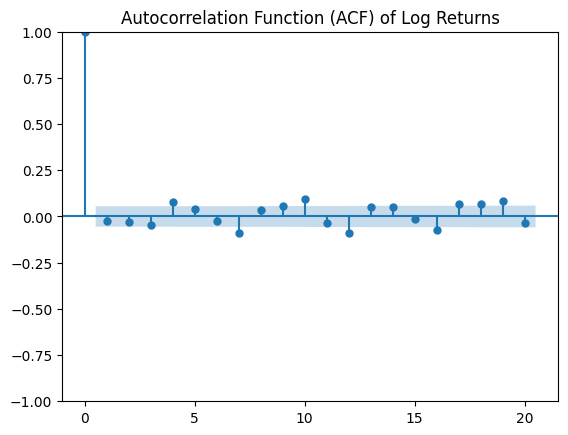

Ljung-Box Test for Autocorrelation (lags=10):
      lb_stat  lb_pvalue
10  41.980712   0.000008


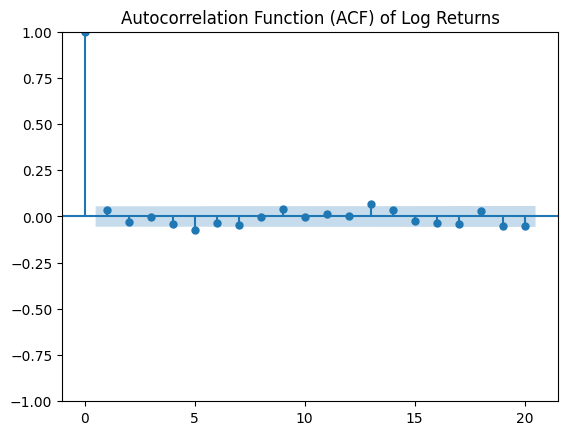

Ljung-Box Test for Autocorrelation (lags=10):
      lb_stat  lb_pvalue
10  17.283599    0.06832


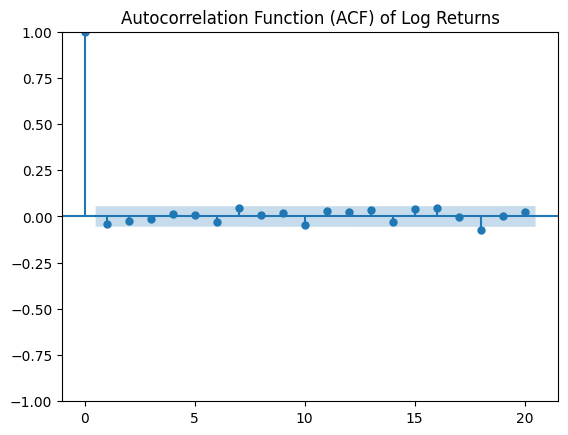

Ljung-Box Test for Autocorrelation (lags=10):
      lb_stat  lb_pvalue
10  10.509729   0.396966


In [13]:
for etf in etfs:
  # Autocorrelation plot to check for persistence
  plot_acf(log_returns[etf], lags=20)
  plt.title("Autocorrelation Function (ACF) of Log Returns")
  plt.show()

  # Ljung-Box test for autocorrelation
  ljung_box_result = acorr_ljungbox(log_returns[etf], lags=[10], return_df=True)
  print("Ljung-Box Test for Autocorrelation (lags=10):")
  print(ljung_box_result)

And finally we will do the ADF test to confirm for our stationarity in our dataset and the ADFtest suggest that our data is indeed stationary.

In [14]:
def test_stationarity(series, name):
    result = adfuller(series)
    print(f"ADF Statistic for {name}: {result[0]:.4f}")
    print(f"p-value for {name}: {result[1]:.4f}")

for etf in etfs:
    test_stationarity(log_returns[etf].dropna(), etf)

ADF Statistic for SPY: -10.8025
p-value for SPY: 0.0000
ADF Statistic for TLT: -10.6434
p-value for TLT: 0.0000
ADF Statistic for SHY: -6.6507
p-value for SHY: 0.0000
ADF Statistic for GLD: -15.4176
p-value for GLD: 0.0000
ADF Statistic for DBO: -36.9405
p-value for DBO: 0.0000


## Step 2

Now In this step we will build DL models using RNN, here how we are going to do  :



*   We will first build a DL model that uses LSTM network architecture for each of the 5 different asset classes, to predict the 25-day ahead return of each ETF.

*  After that we will Train each 5 models and do an in sample predective performance and also Test each of the model out of sample and compare the results of both across the assets.

* Then we will a trading strategy that uses the out-of-sample predection of all the different models and the backtest it check our predective performance.




### Data prep

We will first start with our data prepration, we will first copy the log returns in a new data set to work further, and prepare it accordingly so that the data can be used as input for each model.

In [15]:
df = log_returns.copy()

In [16]:
df

Ticker           SPY       TLT       SHY       GLD       DBO
2018-01-03  0.006305  0.004770  0.000000 -0.002640  0.021360
2018-01-04  0.004206 -0.000159 -0.000477  0.005114  0.001919
2018-01-05  0.006642 -0.002860  0.000000 -0.001037 -0.004805
2018-01-08  0.001827 -0.000637  0.000000 -0.000160  0.005764
2018-01-09  0.002261 -0.013463 -0.000358 -0.004639  0.017094
...              ...       ...       ...       ...       ...
2022-12-22 -0.014369 -0.000193 -0.000614 -0.012159 -0.007486
2022-12-23  0.005736 -0.014769 -0.000492  0.002994  0.024293
2022-12-27 -0.003951 -0.019971 -0.001354  0.008395  0.007307
2022-12-28 -0.012506 -0.005909  0.000000 -0.004516 -0.010645
2022-12-29  0.017840  0.011287  0.000739  0.005583 -0.004693

[1257 rows x 5 columns]

In [17]:
df.reset_index(inplace=True)

# Rename 'Ticker' to 'Date'
df.rename(columns={"index": "Date"}, inplace=True)

df

Ticker        Date       SPY       TLT       SHY       GLD       DBO
0       2018-01-03  0.006305  0.004770  0.000000 -0.002640  0.021360
1       2018-01-04  0.004206 -0.000159 -0.000477  0.005114  0.001919
2       2018-01-05  0.006642 -0.002860  0.000000 -0.001037 -0.004805
3       2018-01-08  0.001827 -0.000637  0.000000 -0.000160  0.005764
4       2018-01-09  0.002261 -0.013463 -0.000358 -0.004639  0.017094
...            ...       ...       ...       ...       ...       ...
1252    2022-12-22 -0.014369 -0.000193 -0.000614 -0.012159 -0.007486
1253    2022-12-23  0.005736 -0.014769 -0.000492  0.002994  0.024293
1254    2022-12-27 -0.003951 -0.019971 -0.001354  0.008395  0.007307
1255    2022-12-28 -0.012506 -0.005909  0.000000 -0.004516 -0.010645
1256    2022-12-29  0.017840  0.011287  0.000739  0.005583 -0.004693

[1257 rows x 6 columns]

In [18]:
df = df.reindex(
    columns=[
        "Date",
        "SPY",
        "TLT",
        "SHY",
        "GLD",
        "DBO",
    ]
)

df.head()


Ticker        Date       SPY       TLT       SHY       GLD       DBO
0       2018-01-03  0.006305  0.004770  0.000000 -0.002640  0.021360
1       2018-01-04  0.004206 -0.000159 -0.000477  0.005114  0.001919
2       2018-01-05  0.006642 -0.002860  0.000000 -0.001037 -0.004805
3       2018-01-08  0.001827 -0.000637  0.000000 -0.000160  0.005764
4       2018-01-09  0.002261 -0.013463 -0.000358 -0.004639  0.017094

### All model description :

Here is the model description for all the models, As we are using same data structure, LSTM architecture we are going to define our models workflow at one go here:

* First we will prepare the data for each model as we have to build individual model for each ETF, in this we will copy only the required ETF that is needed for that model

* Then we will prepare the data for input by doing some feature engineering in which we will calculate 1-day, 10-days, and 50-days cumulative returns of repective ETF to predict the 25-day ahead return.

* After that we will define our data into train, test and validation set, also we will also have an window i.e sequence length of 30 as we are using LSTM architecture.

* In the next step we will we will scale the different variables under the min max scalar to ease our computation then finally we will split the data in train and test split.

* Now Finally we will define our LSTM model architecture, which will be same for all the respective ETF models :

> our model architecture consists of a sequential LSTM network which we have designed for regression. It begins with stacking three LSTM layers, each containing 50 units and utilizing the tanh activation function, with L2 regularization (L2=0.01) applied to the kernel weights to prevent overfitting. The first two LSTM layers return sequences, allowing the propagation of sequential information through the network, while the third LSTM layer does not return sequences, outputting only the final hidden state. Each LSTM layer is followed by a dropout layer with a dropout rate of 0.2, ensuring robustness and generalization. After the LSTM layers, a dense layer with 20 units and ReLU activation is added, followed by another dropout layer. The network ends with an output layer comprising a single neuron with a linear activation function, suitable for regression predictions. The model is compiled with the Adam optimizer, using a learning rate of 1e-4, and the loss function is mean absolute error (MAE). Early stopping is also included to monitor the validation loss, with a patience of 5 epochs and the ability to restore the best-performing weights.

* After that we will final features (learning rate, loss function, early stopping criteria, batch size, ...) and train the model, and after training we need to do the job of testing and to find how our model is performing we will do and final features (learning rate, loss function, early stopping criteria, batch size, ...) and train the model, and to check the perfomance of our model we will do an out of sample predection using the standard out-of-sample R-squared measured and check the results.

### LSTM Model 1 : SPY

In [19]:
df_spy = df[["Date", "SPY"]].copy()
df_spy

Ticker        Date       SPY
0       2018-01-03  0.006305
1       2018-01-04  0.004206
2       2018-01-05  0.006642
3       2018-01-08  0.001827
4       2018-01-09  0.002261
...            ...       ...
1252    2022-12-22 -0.014369
1253    2022-12-23  0.005736
1254    2022-12-27 -0.003951
1255    2022-12-28 -0.012506
1256    2022-12-29  0.017840

[1257 rows x 2 columns]

In [20]:
df_spy["Ret_10"] = df_spy["SPY"].rolling(10).apply(lambda x: np.exp(np.sum(x)) - 1)
df_spy["Ret_50"] = df_spy["SPY"].rolling(50).apply(lambda x: np.exp(np.sum(x)) - 1)
df_spy["Ret_25"] = df_spy["SPY"].rolling(25).apply(lambda x: np.exp(np.sum(x)) - 1)

df_spy["Ret25"] = df_spy["Ret_25"].shift(-25)
del df_spy["Ret_25"]
df_spy = df_spy.dropna()
df_spy.head()

Ticker        Date       SPY    Ret_10    Ret_50     Ret25
49      2018-03-15 -0.001090  0.027269  0.023180 -0.030509
50      2018-03-16 -0.002913  0.019028  0.013791 -0.027826
51      2018-03-19 -0.013623 -0.006246 -0.004124 -0.027764
52      2018-03-20  0.001699 -0.007073 -0.009034 -0.027016
53      2018-03-21 -0.001921 -0.008615 -0.012741 -0.015235

In [21]:
Xdf, ydf = df_spy.iloc[:, 1:-1], df_spy.iloc[:, -1]
X = Xdf.astype("float32")
y = ydf.astype("float32")

In [22]:
val_split = 0.2
train_split = 0.625
train_size = int(len(df_spy) * train_split)
val_size = int(train_size * val_split)
test_size = int(len(df_spy) - train_size)

window_size = 30

ts = test_size
split_time = len(df_spy) - ts
test_time = df_spy.iloc[split_time + window_size :, 0:1].values


y_train_set = y[:split_time]
y_test_set = y[split_time:]

X_train_set = X[:split_time]
X_test_set = X[split_time:]

n_features = X_train_set.shape[1]

In [23]:
scaler_input = MinMaxScaler(feature_range=(-1, 1))
scaler_input.fit(X_train_set)
X_train_set_scaled = scaler_input.transform(X_train_set)
X_test_set_scaled = scaler_input.transform(X_test_set)

mean_ret = np.mean(y_train_set)

scaler_output = MinMaxScaler(feature_range=(-1, 1))
y_train_set = y_train_set.values.reshape(len(y_train_set), 1)
y_test_set = y_test_set.values.reshape(len(y_test_set), 1)
scaler_output.fit(y_train_set)
y_train_set_scaled = scaler_output.transform(y_train_set)

In [24]:
training_time = df_spy.iloc[:split_time, 0:1].values

X_train = []
y_train = []

for i in range(window_size, y_train_set_scaled.shape[0]):
    X_train.append(X_train_set_scaled[i - window_size : i, :])
    y_train.append(y_train_set_scaled[i])

X_train, y_train = np.array(X_train), np.array(y_train)

print("Shape of training data", X_train.shape, y_train.shape)

X_test = []
y_test = y_test_set

for i in range(window_size, y_test_set.shape[0]):
    X_test.append(X_test_set_scaled[i - window_size : i, :])

X_test, y_test = np.array(X_test), np.array(y_test)

print("Shape of test data", X_test.shape, y_test.shape)

Shape of training data (709, 30, 3) (709, 1)
Shape of test data (414, 30, 3) (444, 1)


In [25]:
from keras.regularizers import l2
from keras.optimizers import Adam

In [26]:
SEED = 321
# Define hyperparameters
units_lstm = 50
n_dropout = 0.2
act_fun = "relu"

# Define the model
model = Sequential()

# First LSTM layer with Tanh activation and L2 regularization
model.add(
    LSTM(
        units=units_lstm,
        return_sequences=True,
        activation="tanh",
        input_shape=(X_train.shape[1], n_features),
        kernel_regularizer=l2(0.01)
    )
)
model.add(Dropout(n_dropout, seed=SEED))

# Second LSTM layer with Tanh activation and L2 regularization
model.add(LSTM(units=units_lstm, return_sequences=True, activation="tanh", kernel_regularizer=l2(0.01)))
model.add(Dropout(n_dropout, seed=SEED))

# Third LSTM layer with Tanh activation and L2 regularization
model.add(LSTM(units=units_lstm, return_sequences=False, activation="tanh", kernel_regularizer=l2(0.01)))
model.add(Dropout(n_dropout, seed=SEED))

# Dense layer with ReLU activation
model.add(Dense(units=20, activation=act_fun))
model.add(Dropout(n_dropout, seed=SEED))

# Output layer with Linear activation (for regression)
model.add(Dense(units=1, activation='linear'))

# Compile the model with Adam optimizer and MAE loss
hp_lr = 1e-4
model.compile(optimizer=Adam(learning_rate=hp_lr), loss='mean_absolute_error')

es = EarlyStopping(
    monitor="val_loss", mode="min", verbose=0, patience=5, restore_best_weights=True
)

# Summary of the model
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 50)              │          10,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 30, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │           1,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,241 (204.07 KB)

 Trainable params: 52,241 (204.07 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# fit the models
model.fit(
    X_train,
    y_train,
    validation_split=val_split,
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=[es],
)

Epoch 1/100
9/9 - 6s - 635ms/step - loss: 1.8691 - val_loss: 1.8151
Epoch 2/100
9/9 - 2s - 223ms/step - loss: 1.8311 - val_loss: 1.7757
Epoch 3/100
9/9 - 0s - 32ms/step - loss: 1.7961 - val_loss: 1.7382
Epoch 4/100
9/9 - 0s - 16ms/step - loss: 1.7606 - val_loss: 1.7012
Epoch 5/100
9/9 - 0s - 16ms/step - loss: 1.7251 - val_loss: 1.6626
Epoch 6/100
9/9 - 0s - 17ms/step - loss: 1.6906 - val_loss: 1.6211
Epoch 7/100
9/9 - 0s - 14ms/step - loss: 1.6544 - val_loss: 1.5800
Epoch 8/100
9/9 - 0s - 17ms/step - loss: 1.6255 - val_loss: 1.5423
Epoch 9/100
9/9 - 0s - 37ms/step - loss: 1.5989 - val_loss: 1.5150
Epoch 10/100
9/9 - 0s - 34ms/step - loss: 1.5734 - val_loss: 1.4945
Epoch 11/100
9/9 - 0s - 33ms/step - loss: 1.5477 - val_loss: 1.4730
Epoch 12/100
9/9 - 0s - 21ms/step - loss: 1.5250 - val_loss: 1.4521
Epoch 13/100
9/9 - 0s - 34ms/step - loss: 1.5027 - val_loss: 1.4292
Epoch 14/100
9/9 - 0s - 21ms/step - loss: 1.4784 - val_loss: 1.4054
Epoch 15/100
9/9 - 0s - 23ms/step - loss: 1.4541 - val_

In [28]:
#Train and test

prediction = model.predict(X_test)
prediction = scaler_output.inverse_transform(prediction)
prediction = prediction.flatten()

values = np.array(y_test[window_size:])
values = values.flatten()


def R2_campbell(y_true, y_predicted, mean_ret):
    y_predicted = y_predicted.reshape((-1,))
    sse = sum((y_true - y_predicted) ** 2)
    tse = sum((y_true - mean_ret) ** 2)
    r2_score = 1 - (sse / tse)

    return r2_score


R2_Campbell = R2_campbell(values, prediction, mean_ret)
print("Out-of-sample R-squared:", R2_Campbell)

# %%
df_predictions = pd.DataFrame(
    {"Date": test_time.flatten(), "Pred LSTM": prediction, "values": values}
)
df_predictions.head()


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Out-of-sample R-squared: -0.07894918546054952


Date  Pred LSTM    values
0  2021-04-06   0.012331  0.019920
1  2021-04-07   0.012389 -0.002902
2  2021-04-08   0.012460  0.004308
3  2021-04-09   0.012442  0.012370
4  2021-04-12   0.012460  0.009426

#####convert to numpy to evaluate

In [29]:
df1_actual=df_predictions[['values']].to_numpy()
df1_pred=df_predictions[['Pred LSTM']].to_numpy()

### LSTM Model 2 : TLT

In [30]:
df_tlt = df[["Date", "TLT"]].copy()
df_tlt

Ticker        Date       TLT
0       2018-01-03  0.004770
1       2018-01-04 -0.000159
2       2018-01-05 -0.002860
3       2018-01-08 -0.000637
4       2018-01-09 -0.013463
...            ...       ...
1252    2022-12-22 -0.000193
1253    2022-12-23 -0.014769
1254    2022-12-27 -0.019971
1255    2022-12-28 -0.005909
1256    2022-12-29  0.011287

[1257 rows x 2 columns]

In [31]:
df_tlt["Ret_10"] = df_tlt["TLT"].rolling(10).apply(lambda x: np.exp(np.sum(x)) - 1)
df_tlt["Ret_50"] = df_tlt["TLT"].rolling(50).apply(lambda x: np.exp(np.sum(x)) - 1)
df_tlt["Ret_25"] = df_tlt["TLT"].rolling(25).apply(lambda x: np.exp(np.sum(x)) - 1)

df_tlt["Ret25"] = df_tlt["Ret_25"].shift(-25)
del df_tlt["Ret_25"]
df_tlt = df_tlt.dropna()
df_tlt.head()

Ticker        Date       TLT    Ret_10    Ret_50     Ret25
49      2018-03-15  0.000000  0.007710 -0.041836 -0.014804
50      2018-03-16 -0.003583  0.012336 -0.049806 -0.011017
51      2018-03-19 -0.003177  0.011861 -0.052669 -0.012392
52      2018-03-20 -0.004027  0.006856 -0.053775 -0.015048
53      2018-03-21  0.001092  0.009067 -0.052137 -0.009237

In [32]:
Xdf, ydf = df_tlt.iloc[:, 1:-1], df_tlt.iloc[:, -1]
X = Xdf.astype("float32")
y = ydf.astype("float32")

In [33]:
val_split = 0.2
train_split = 0.625
train_size = int(len(df_tlt) * train_split)
val_size = int(train_size * val_split)
test_size = int(len(df_tlt) - train_size)

window_size = 30

ts = test_size
split_time = len(df_tlt) - ts
test_time = df_tlt.iloc[split_time + window_size :, 0:1].values


y_train_set = y[:split_time]
y_test_set = y[split_time:]

X_train_set = X[:split_time]
X_test_set = X[split_time:]

n_features = X_train_set.shape[1]

In [34]:
scaler_input = MinMaxScaler(feature_range=(-1, 1))
scaler_input.fit(X_train_set)
X_train_set_scaled = scaler_input.transform(X_train_set)
X_test_set_scaled = scaler_input.transform(X_test_set)

mean_ret = np.mean(y_train_set)

scaler_output = MinMaxScaler(feature_range=(-1, 1))
y_train_set = y_train_set.values.reshape(len(y_train_set), 1)
y_test_set = y_test_set.values.reshape(len(y_test_set), 1)
scaler_output.fit(y_train_set)
y_train_set_scaled = scaler_output.transform(y_train_set)

In [35]:
training_time = df_tlt.iloc[:split_time, 0:1].values

X_train = []
y_train = []

for i in range(window_size, y_train_set_scaled.shape[0]):
    X_train.append(X_train_set_scaled[i - window_size : i, :])
    y_train.append(y_train_set_scaled[i])

X_train, y_train = np.array(X_train), np.array(y_train)

print("Shape of training data", X_train.shape, y_train.shape)

X_test = []
y_test = y_test_set

for i in range(window_size, y_test_set.shape[0]):
    X_test.append(X_test_set_scaled[i - window_size : i, :])

X_test, y_test = np.array(X_test), np.array(y_test)

print("Shape of test data", X_test.shape, y_test.shape)

Shape of training data (709, 30, 3) (709, 1)
Shape of test data (414, 30, 3) (444, 1)


In [36]:
from keras.regularizers import l2
from keras.optimizers import Adam

In [37]:
SEED = 321
# Define hyperparameters
units_lstm = 50
n_dropout = 0.2
act_fun = "relu"

# Define the model
model = Sequential()

# First LSTM layer with Tanh activation and L2 regularization
model.add(
    LSTM(
        units=units_lstm,
        return_sequences=True,
        activation="tanh",
        input_shape=(X_train.shape[1], n_features),
        kernel_regularizer=l2(0.01)
    )
)
model.add(Dropout(n_dropout, seed=SEED))

# Second LSTM layer with Tanh activation and L2 regularization
model.add(LSTM(units=units_lstm, return_sequences=True, activation="tanh", kernel_regularizer=l2(0.01)))
model.add(Dropout(n_dropout, seed=SEED))

# Third LSTM layer with Tanh activation and L2 regularization
model.add(LSTM(units=units_lstm, return_sequences=False, activation="tanh", kernel_regularizer=l2(0.01)))
model.add(Dropout(n_dropout, seed=SEED))

# Dense layer with ReLU activation
model.add(Dense(units=20, activation=act_fun))
model.add(Dropout(n_dropout, seed=SEED))

# Output layer with Linear activation (for regression)
model.add(Dense(units=1, activation='linear'))

# Compile the model with Adam optimizer and MAE loss
hp_lr = 1e-4
model.compile(optimizer=Adam(learning_rate=hp_lr), loss='mean_absolute_error')

es = EarlyStopping(
    monitor="val_loss", mode="min", verbose=0, patience=5, restore_best_weights=True
)

# Summary of the model
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 30, 50)              │          10,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 30, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 20)                  │           1,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,241 (204.07 KB)

 Trainable params: 52,241 (204.07 KB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# fit the models
model.fit(
    X_train,
    y_train,
    validation_split=val_split,
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=[es],
)

Epoch 1/100
9/9 - 3s - 315ms/step - loss: 1.9529 - val_loss: 2.1209
Epoch 2/100
9/9 - 0s - 16ms/step - loss: 1.9110 - val_loss: 2.0576
Epoch 3/100
9/9 - 0s - 18ms/step - loss: 1.8793 - val_loss: 2.0017
Epoch 4/100
9/9 - 0s - 32ms/step - loss: 1.8439 - val_loss: 1.9505
Epoch 5/100
9/9 - 0s - 16ms/step - loss: 1.8129 - val_loss: 1.8951
Epoch 6/100
9/9 - 0s - 15ms/step - loss: 1.7825 - val_loss: 1.8407
Epoch 7/100
9/9 - 0s - 16ms/step - loss: 1.7498 - val_loss: 1.7965
Epoch 8/100
9/9 - 0s - 16ms/step - loss: 1.7191 - val_loss: 1.7614
Epoch 9/100
9/9 - 0s - 14ms/step - loss: 1.6971 - val_loss: 1.7394
Epoch 10/100
9/9 - 0s - 15ms/step - loss: 1.6696 - val_loss: 1.7168
Epoch 11/100
9/9 - 0s - 15ms/step - loss: 1.6447 - val_loss: 1.7092
Epoch 12/100
9/9 - 0s - 14ms/step - loss: 1.6196 - val_loss: 1.6813
Epoch 13/100
9/9 - 0s - 15ms/step - loss: 1.5922 - val_loss: 1.6642
Epoch 14/100
9/9 - 0s - 13ms/step - loss: 1.5702 - val_loss: 1.6447
Epoch 15/100
9/9 - 0s - 14ms/step - loss: 1.5465 - val_l

In [39]:
#Train and test

prediction = model.predict(X_test)
prediction = scaler_output.inverse_transform(prediction)
prediction = prediction.flatten()

values = np.array(y_test[window_size:])
values = values.flatten()


def R2_campbell(y_true, y_predicted, mean_ret):
    y_predicted = y_predicted.reshape((-1,))
    sse = sum((y_true - y_predicted) ** 2)
    tse = sum((y_true - mean_ret) ** 2)
    r2_score = 1 - (sse / tse)

    return r2_score


R2_Campbell = R2_campbell(values, prediction, mean_ret)
print("Out-of-sample R-squared:", R2_Campbell)

# %%
df_predictions = pd.DataFrame(
    {"Date": test_time.flatten(), "Pred LSTM": prediction, "values": values}
)
df_predictions.head()


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Out-of-sample R-squared: -0.14217422275184166


Date  Pred LSTM    values
0  2021-04-06   0.019597 -0.005804
1  2021-04-07   0.019484 -0.009351
2  2021-04-08   0.019378 -0.015941
3  2021-04-09   0.019264 -0.003127
4  2021-04-12   0.019132 -0.004802

In [40]:
df2_actual=df_predictions[['values']].to_numpy()
df2_pred=df_predictions[['Pred LSTM']].to_numpy()

### LSTM Model 3 : SHY

In [41]:
df_shy = df[["Date", "SHY"]].copy()
df_shy

Ticker        Date       SHY
0       2018-01-03  0.000000
1       2018-01-04 -0.000477
2       2018-01-05  0.000000
3       2018-01-08  0.000000
4       2018-01-09 -0.000358
...            ...       ...
1252    2022-12-22 -0.000614
1253    2022-12-23 -0.000492
1254    2022-12-27 -0.001354
1255    2022-12-28  0.000000
1256    2022-12-29  0.000739

[1257 rows x 2 columns]

In [42]:
df_shy["Ret_10"] = df_shy["SHY"].rolling(10).apply(lambda x: np.exp(np.sum(x)) - 1)
df_shy["Ret_50"] = df_shy["SHY"].rolling(50).apply(lambda x: np.exp(np.sum(x)) - 1)
df_shy["Ret_25"] = df_shy["SHY"].rolling(25).apply(lambda x: np.exp(np.sum(x)) - 1)

df_shy["Ret25"] = df_shy["Ret_25"].shift(-25)
del df_shy["Ret_25"]
df_shy = df_shy.dropna()
df_shy.head()

Ticker        Date       SHY   Ret_10    Ret_50     Ret25
49      2018-03-15  0.000120 -0.00024 -0.004414 -0.002277
50      2018-03-16 -0.000479 -0.00024 -0.004891 -0.001918
51      2018-03-19  0.000000 -0.00024 -0.004416 -0.001679
52      2018-03-20 -0.000360 -0.00036 -0.004774 -0.001439
53      2018-03-21  0.000719  0.00036 -0.004058 -0.001918

In [43]:
Xdf, ydf = df_shy.iloc[:, 1:-1], df_shy.iloc[:, -1]
X = Xdf.astype("float32")
y = ydf.astype("float32")

In [44]:
val_split = 0.2
train_split = 0.625
train_size = int(len(df_shy) * train_split)
val_size = int(train_size * val_split)
test_size = int(len(df_shy) - train_size)

window_size = 30

ts = test_size
split_time = len(df_shy) - ts
test_time = df_shy.iloc[split_time + window_size :, 0:1].values


y_train_set = y[:split_time]
y_test_set = y[split_time:]

X_train_set = X[:split_time]
X_test_set = X[split_time:]

n_features = X_train_set.shape[1]

In [45]:
scaler_input = MinMaxScaler(feature_range=(-1, 1))
scaler_input.fit(X_train_set)
X_train_set_scaled = scaler_input.transform(X_train_set)
X_test_set_scaled = scaler_input.transform(X_test_set)

mean_ret = np.mean(y_train_set)

scaler_output = MinMaxScaler(feature_range=(-1, 1))
y_train_set = y_train_set.values.reshape(len(y_train_set), 1)
y_test_set = y_test_set.values.reshape(len(y_test_set), 1)
scaler_output.fit(y_train_set)
y_train_set_scaled = scaler_output.transform(y_train_set)

In [46]:
training_time = df_shy.iloc[:split_time, 0:1].values

X_train = []
y_train = []

for i in range(window_size, y_train_set_scaled.shape[0]):
    X_train.append(X_train_set_scaled[i - window_size : i, :])
    y_train.append(y_train_set_scaled[i])

X_train, y_train = np.array(X_train), np.array(y_train)

print("Shape of training data", X_train.shape, y_train.shape)

X_test = []
y_test = y_test_set

for i in range(window_size, y_test_set.shape[0]):
    X_test.append(X_test_set_scaled[i - window_size : i, :])

X_test, y_test = np.array(X_test), np.array(y_test)

print("Shape of test data", X_test.shape, y_test.shape)

Shape of training data (709, 30, 3) (709, 1)
Shape of test data (414, 30, 3) (444, 1)


In [47]:
from keras.regularizers import l2
from keras.optimizers import Adam

In [48]:
SEED = 321
# Define hyperparameters
units_lstm = 50
n_dropout = 0.2
act_fun = "relu"

# Define the model
model = Sequential()

# First LSTM layer with Tanh activation and L2 regularization
model.add(
    LSTM(
        units=units_lstm,
        return_sequences=True,
        activation="tanh",
        input_shape=(X_train.shape[1], n_features),
        kernel_regularizer=l2(0.01)
    )
)
model.add(Dropout(n_dropout, seed=SEED))

# Second LSTM layer with Tanh activation and L2 regularization
model.add(LSTM(units=units_lstm, return_sequences=True, activation="tanh", kernel_regularizer=l2(0.01)))
model.add(Dropout(n_dropout, seed=SEED))

# Third LSTM layer with Tanh activation and L2 regularization
model.add(LSTM(units=units_lstm, return_sequences=False, activation="tanh", kernel_regularizer=l2(0.01)))
model.add(Dropout(n_dropout, seed=SEED))

# Dense layer with ReLU activation
model.add(Dense(units=20, activation=act_fun))
model.add(Dropout(n_dropout, seed=SEED))

# Output layer with Linear activation (for regression)
model.add(Dense(units=1, activation='linear'))

# Compile the model with Adam optimizer and MAE loss
hp_lr = 1e-4
model.compile(optimizer=Adam(learning_rate=hp_lr), loss='mean_absolute_error')

es = EarlyStopping(
    monitor="val_loss", mode="min", verbose=0, patience=5, restore_best_weights=True
)

# Summary of the model
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 30, 50)              │          10,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 30, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_8 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 20)                  │           1,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,241 (204.07 KB)

 Trainable params: 52,241 (204.07 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# fit the models
model.fit(
    X_train,
    y_train,
    validation_split=val_split,
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=[es],
)

Epoch 1/100
9/9 - 4s - 430ms/step - loss: 2.1008 - val_loss: 2.1303
Epoch 2/100
9/9 - 0s - 18ms/step - loss: 2.0270 - val_loss: 2.0254
Epoch 3/100
9/9 - 0s - 17ms/step - loss: 1.9537 - val_loss: 1.8989
Epoch 4/100
9/9 - 0s - 15ms/step - loss: 1.8778 - val_loss: 1.7493
Epoch 5/100
9/9 - 0s - 15ms/step - loss: 1.8403 - val_loss: 1.6237
Epoch 6/100
9/9 - 0s - 15ms/step - loss: 1.8068 - val_loss: 1.5883
Epoch 7/100
9/9 - 0s - 14ms/step - loss: 1.7750 - val_loss: 1.5899
Epoch 8/100
9/9 - 0s - 16ms/step - loss: 1.7410 - val_loss: 1.5906
Epoch 9/100
9/9 - 0s - 14ms/step - loss: 1.7184 - val_loss: 1.5748
Epoch 10/100
9/9 - 0s - 15ms/step - loss: 1.6934 - val_loss: 1.5540
Epoch 11/100
9/9 - 0s - 13ms/step - loss: 1.6637 - val_loss: 1.5279
Epoch 12/100
9/9 - 0s - 16ms/step - loss: 1.6400 - val_loss: 1.5181
Epoch 13/100
9/9 - 0s - 16ms/step - loss: 1.6151 - val_loss: 1.5054
Epoch 14/100
9/9 - 0s - 14ms/step - loss: 1.5869 - val_loss: 1.5087
Epoch 15/100
9/9 - 0s - 16ms/step - loss: 1.5662 - val_l

In [50]:
#Train and test

prediction = model.predict(X_test)
prediction = scaler_output.inverse_transform(prediction)
prediction = prediction.flatten()

values = np.array(y_test[window_size:])
values = values.flatten()


def R2_campbell(y_true, y_predicted, mean_ret):
    y_predicted = y_predicted.reshape((-1,))
    sse = sum((y_true - y_predicted) ** 2)
    tse = sum((y_true - mean_ret) ** 2)
    r2_score = 1 - (sse / tse)

    return r2_score


R2_Campbell = R2_campbell(values, prediction, mean_ret)
print("Out-of-sample R-squared:", R2_Campbell)

# %%
df_predictions = pd.DataFrame(
    {"Date": test_time.flatten(), "Pred LSTM": prediction, "values": values}
)
df_predictions.head()


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Out-of-sample R-squared: 0.04833190355893968


Date  Pred LSTM    values
0  2021-04-06   0.001095  0.000464
1  2021-04-07   0.001111  0.000232
2  2021-04-08   0.001126  0.000116
3  2021-04-09   0.001138  0.000464
4  2021-04-12   0.001163  0.000696

In [51]:
df3_actual=df_predictions[['values']].to_numpy()
df3_pred=df_predictions[['Pred LSTM']].to_numpy()

### LSTM Model 4 : GLD

In [52]:
df_gld = df[["Date", "GLD"]].copy()
df_gld

Ticker        Date       GLD
0       2018-01-03 -0.002640
1       2018-01-04  0.005114
2       2018-01-05 -0.001037
3       2018-01-08 -0.000160
4       2018-01-09 -0.004639
...            ...       ...
1252    2022-12-22 -0.012159
1253    2022-12-23  0.002994
1254    2022-12-27  0.008395
1255    2022-12-28 -0.004516
1256    2022-12-29  0.005583

[1257 rows x 2 columns]

In [53]:
df_gld["Ret_10"] = df_gld["GLD"].rolling(10).apply(lambda x: np.exp(np.sum(x)) - 1)
df_gld["Ret_50"] = df_gld["GLD"].rolling(50).apply(lambda x: np.exp(np.sum(x)) - 1)
df_gld["Ret_25"] = df_gld["GLD"].rolling(25).apply(lambda x: np.exp(np.sum(x)) - 1)

df_gld["Ret25"] = df_gld["Ret_25"].shift(-25)
del df_gld["Ret_25"]
df_gld = df_gld.dropna()
df_gld.head()

Ticker        Date       GLD    Ret_10    Ret_50     Ret25
49      2018-03-15 -0.006385  0.001443 -0.001998  0.013851
50      2018-03-16 -0.002405 -0.006300 -0.001763  0.008186
51      2018-03-19  0.002165 -0.002476 -0.004703  0.010891
52      2018-03-20 -0.004495 -0.017545 -0.008139  0.008849
53      2018-03-21  0.017306  0.006045  0.009337 -0.011939

In [54]:
Xdf, ydf = df_gld.iloc[:, 1:-1], df_gld.iloc[:, -1]
X = Xdf.astype("float32")
y = ydf.astype("float32")

In [55]:
val_split = 0.2
train_split = 0.625
train_size = int(len(df_gld) * train_split)
val_size = int(train_size * val_split)
test_size = int(len(df_gld) - train_size)

window_size = 30

ts = test_size
split_time = len(df_gld) - ts
test_time = df_gld.iloc[split_time + window_size :, 0:1].values


y_train_set = y[:split_time]
y_test_set = y[split_time:]

X_train_set = X[:split_time]
X_test_set = X[split_time:]

n_features = X_train_set.shape[1]

In [56]:
scaler_input = MinMaxScaler(feature_range=(-1, 1))
scaler_input.fit(X_train_set)
X_train_set_scaled = scaler_input.transform(X_train_set)
X_test_set_scaled = scaler_input.transform(X_test_set)

mean_ret = np.mean(y_train_set)

scaler_output = MinMaxScaler(feature_range=(-1, 1))
y_train_set = y_train_set.values.reshape(len(y_train_set), 1)
y_test_set = y_test_set.values.reshape(len(y_test_set), 1)
scaler_output.fit(y_train_set)
y_train_set_scaled = scaler_output.transform(y_train_set)

In [57]:
training_time = df_gld.iloc[:split_time, 0:1].values

X_train = []
y_train = []

for i in range(window_size, y_train_set_scaled.shape[0]):
    X_train.append(X_train_set_scaled[i - window_size : i, :])
    y_train.append(y_train_set_scaled[i])

X_train, y_train = np.array(X_train), np.array(y_train)

print("Shape of training data", X_train.shape, y_train.shape)

X_test = []
y_test = y_test_set

for i in range(window_size, y_test_set.shape[0]):
    X_test.append(X_test_set_scaled[i - window_size : i, :])

X_test, y_test = np.array(X_test), np.array(y_test)

print("Shape of test data", X_test.shape, y_test.shape)

Shape of training data (709, 30, 3) (709, 1)
Shape of test data (414, 30, 3) (444, 1)


In [58]:
from keras.regularizers import l2
from keras.optimizers import Adam

In [59]:
SEED = 321
# Define hyperparameters
units_lstm = 50
n_dropout = 0.2
act_fun = "relu"

# Define the model
model = Sequential()

# First LSTM layer with Tanh activation and L2 regularization
model.add(
    LSTM(
        units=units_lstm,
        return_sequences=True,
        activation="tanh",
        input_shape=(X_train.shape[1], n_features),
        kernel_regularizer=l2(0.01)
    )
)
model.add(Dropout(n_dropout, seed=SEED))

# Second LSTM layer with Tanh activation and L2 regularization
model.add(LSTM(units=units_lstm, return_sequences=True, activation="tanh", kernel_regularizer=l2(0.01)))
model.add(Dropout(n_dropout, seed=SEED))

# Third LSTM layer with Tanh activation and L2 regularization
model.add(LSTM(units=units_lstm, return_sequences=False, activation="tanh", kernel_regularizer=l2(0.01)))
model.add(Dropout(n_dropout, seed=SEED))

# Dense layer with ReLU activation
model.add(Dense(units=20, activation=act_fun))
model.add(Dropout(n_dropout, seed=SEED))

# Output layer with Linear activation (for regression)
model.add(Dense(units=1, activation='linear'))

# Compile the model with Adam optimizer and MAE loss
hp_lr = 1e-4
model.compile(optimizer=Adam(learning_rate=hp_lr), loss='mean_absolute_error')

es = EarlyStopping(
    monitor="val_loss", mode="min", verbose=0, patience=5, restore_best_weights=True
)

# Summary of the model
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                        │ (None, 30, 50)              │          10,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_10 (LSTM)                       │ (None, 30, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_11 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 20)                  │           1,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,241 (204.07 KB)

 Trainable params: 52,241 (204.07 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
# fit the models
model.fit(
    X_train,
    y_train,
    validation_split=val_split,
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=[es],
)

Epoch 1/100
9/9 - 3s - 326ms/step - loss: 1.9456 - val_loss: 2.1192
Epoch 2/100
9/9 - 0s - 16ms/step - loss: 1.9096 - val_loss: 2.0731
Epoch 3/100
9/9 - 0s - 16ms/step - loss: 1.8734 - val_loss: 2.0276
Epoch 4/100
9/9 - 0s - 15ms/step - loss: 1.8396 - val_loss: 1.9808
Epoch 5/100
9/9 - 0s - 15ms/step - loss: 1.8092 - val_loss: 1.9343
Epoch 6/100
9/9 - 0s - 15ms/step - loss: 1.7766 - val_loss: 1.8893
Epoch 7/100
9/9 - 0s - 15ms/step - loss: 1.7493 - val_loss: 1.8512
Epoch 8/100
9/9 - 0s - 14ms/step - loss: 1.7220 - val_loss: 1.8173
Epoch 9/100
9/9 - 0s - 17ms/step - loss: 1.6974 - val_loss: 1.7868
Epoch 10/100
9/9 - 0s - 15ms/step - loss: 1.6691 - val_loss: 1.7571
Epoch 11/100
9/9 - 0s - 14ms/step - loss: 1.6466 - val_loss: 1.7301
Epoch 12/100
9/9 - 0s - 14ms/step - loss: 1.6216 - val_loss: 1.7021
Epoch 13/100
9/9 - 0s - 14ms/step - loss: 1.5992 - val_loss: 1.6787
Epoch 14/100
9/9 - 0s - 15ms/step - loss: 1.5765 - val_loss: 1.6553
Epoch 15/100
9/9 - 0s - 13ms/step - loss: 1.5505 - val_l

In [61]:
#Train and test

prediction = model.predict(X_test)
prediction = scaler_output.inverse_transform(prediction)
prediction = prediction.flatten()

values = np.array(y_test[window_size:])
values = values.flatten()


def R2_campbell(y_true, y_predicted, mean_ret):
    y_predicted = y_predicted.reshape((-1,))
    sse = sum((y_true - y_predicted) ** 2)
    tse = sum((y_true - mean_ret) ** 2)
    r2_score = 1 - (sse / tse)

    return r2_score


R2_Campbell = R2_campbell(values, prediction, mean_ret)
print("Out-of-sample R-squared:", R2_Campbell)

# %%
df_predictions = pd.DataFrame(
    {"Date": test_time.flatten(), "Pred LSTM": prediction, "values": values}
)
df_predictions.head()


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Out-of-sample R-squared: -0.0749841115727965


Date  Pred LSTM    values
0  2021-04-06  -0.001686  0.054650
1  2021-04-07  -0.001281  0.047125
2  2021-04-08   0.000052  0.040241
3  2021-04-09   0.001573  0.057696
4  2021-04-12   0.004156  0.076534

In [62]:
df4_actual=df_predictions[['values']].to_numpy()
df4_pred=df_predictions[['Pred LSTM']].to_numpy()

### LSTM Model 5 : DBO

In [63]:
df_dbo = df[["Date", "DBO"]].copy()
df_dbo

Ticker        Date       DBO
0       2018-01-03  0.021360
1       2018-01-04  0.001919
2       2018-01-05 -0.004805
3       2018-01-08  0.005764
4       2018-01-09  0.017094
...            ...       ...
1252    2022-12-22 -0.007486
1253    2022-12-23  0.024293
1254    2022-12-27  0.007307
1255    2022-12-28 -0.010645
1256    2022-12-29 -0.004693

[1257 rows x 2 columns]

In [64]:
df_dbo["Ret_10"] = df_dbo["DBO"].rolling(10).apply(lambda x: np.exp(np.sum(x)) - 1)
df_dbo["Ret_50"] = df_dbo["DBO"].rolling(50).apply(lambda x: np.exp(np.sum(x)) - 1)
df_dbo["Ret_25"] = df_dbo["DBO"].rolling(25).apply(lambda x: np.exp(np.sum(x)) - 1)

df_dbo["Ret25"] = df_dbo["Ret_25"].shift(-25)
del df_dbo["Ret_25"]
df_dbo = df_dbo.dropna()
df_dbo.head()

Ticker        Date       DBO    Ret_10    Ret_50     Ret25
49      2018-03-15  0.002818  0.016206  0.046124  0.098499
50      2018-03-16  0.012121  0.023719  0.036503  0.096386
51      2018-03-19 -0.005576  0.006567  0.028763  0.086673
52      2018-03-20  0.014801  0.020619  0.049133  0.076217
53      2018-03-21  0.026282  0.062738  0.070881  0.054562

In [65]:
Xdf, ydf = df_dbo.iloc[:, 1:-1], df_dbo.iloc[:, -1]
X = Xdf.astype("float32")
y = ydf.astype("float32")

In [66]:
val_split = 0.2
train_split = 0.625
train_size = int(len(df_dbo) * train_split)
val_size = int(train_size * val_split)
test_size = int(len(df_dbo) - train_size)

window_size = 30

ts = test_size
split_time = len(df_dbo) - ts
test_time = df_dbo.iloc[split_time + window_size :, 0:1].values


y_train_set = y[:split_time]
y_test_set = y[split_time:]

X_train_set = X[:split_time]
X_test_set = X[split_time:]

n_features = X_train_set.shape[1]

In [67]:
scaler_input = MinMaxScaler(feature_range=(-1, 1))
scaler_input.fit(X_train_set)
X_train_set_scaled = scaler_input.transform(X_train_set)
X_test_set_scaled = scaler_input.transform(X_test_set)

mean_ret = np.mean(y_train_set)

scaler_output = MinMaxScaler(feature_range=(-1, 1))
y_train_set = y_train_set.values.reshape(len(y_train_set), 1)
y_test_set = y_test_set.values.reshape(len(y_test_set), 1)
scaler_output.fit(y_train_set)
y_train_set_scaled = scaler_output.transform(y_train_set)

In [68]:
training_time = df_dbo.iloc[:split_time, 0:1].values

X_train = []
y_train = []

for i in range(window_size, y_train_set_scaled.shape[0]):
    X_train.append(X_train_set_scaled[i - window_size : i, :])
    y_train.append(y_train_set_scaled[i])

X_train, y_train = np.array(X_train), np.array(y_train)

print("Shape of training data", X_train.shape, y_train.shape)

X_test = []
y_test = y_test_set

for i in range(window_size, y_test_set.shape[0]):
    X_test.append(X_test_set_scaled[i - window_size : i, :])

X_test, y_test = np.array(X_test), np.array(y_test)

print("Shape of test data", X_test.shape, y_test.shape)

Shape of training data (709, 30, 3) (709, 1)
Shape of test data (414, 30, 3) (444, 1)


In [69]:
from keras.regularizers import l2
from keras.optimizers import Adam

In [70]:
SEED = 321
# Define hyperparameters
units_lstm = 50
n_dropout = 0.2
act_fun = "relu"

# Define the model
model = Sequential()

# First LSTM layer with Tanh activation and L2 regularization
model.add(
    LSTM(
        units=units_lstm,
        return_sequences=True,
        activation="tanh",
        input_shape=(X_train.shape[1], n_features),
        kernel_regularizer=l2(0.01)
    )
)
model.add(Dropout(n_dropout, seed=SEED))

# Second LSTM layer with Tanh activation and L2 regularization
model.add(LSTM(units=units_lstm, return_sequences=True, activation="tanh", kernel_regularizer=l2(0.01)))
model.add(Dropout(n_dropout, seed=SEED))

# Third LSTM layer with Tanh activation and L2 regularization
model.add(LSTM(units=units_lstm, return_sequences=False, activation="tanh", kernel_regularizer=l2(0.01)))
model.add(Dropout(n_dropout, seed=SEED))

# Dense layer with ReLU activation
model.add(Dense(units=20, activation=act_fun))
model.add(Dropout(n_dropout, seed=SEED))

# Output layer with Linear activation (for regression)
model.add(Dense(units=1, activation='linear'))

# Compile the model with Adam optimizer and MAE loss
hp_lr = 1e-4
model.compile(optimizer=Adam(learning_rate=hp_lr), loss='mean_absolute_error')

es = EarlyStopping(
    monitor="val_loss", mode="min", verbose=0, patience=5, restore_best_weights=True
)

# Summary of the model
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (None, 30, 50)              │          10,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 30, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_14 (LSTM)                       │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 20)                  │           1,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,241 (204.07 KB)

 Trainable params: 52,241 (204.07 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
# fit the models
model.fit(
    X_train,
    y_train,
    validation_split=val_split,
    epochs=100,
    batch_size=64,
    verbose=2,
    callbacks=[es],
)

Epoch 1/100
9/9 - 3s - 344ms/step - loss: 1.9276 - val_loss: 1.9802
Epoch 2/100
9/9 - 0s - 16ms/step - loss: 1.8887 - val_loss: 1.9347
Epoch 3/100
9/9 - 0s - 16ms/step - loss: 1.8525 - val_loss: 1.8897
Epoch 4/100
9/9 - 0s - 14ms/step - loss: 1.8139 - val_loss: 1.8460
Epoch 5/100
9/9 - 0s - 15ms/step - loss: 1.7832 - val_loss: 1.8063
Epoch 6/100
9/9 - 0s - 15ms/step - loss: 1.7570 - val_loss: 1.7733
Epoch 7/100
9/9 - 0s - 14ms/step - loss: 1.7295 - val_loss: 1.7493
Epoch 8/100
9/9 - 0s - 15ms/step - loss: 1.7025 - val_loss: 1.7257
Epoch 9/100
9/9 - 0s - 15ms/step - loss: 1.6802 - val_loss: 1.7075
Epoch 10/100
9/9 - 0s - 14ms/step - loss: 1.6514 - val_loss: 1.6863
Epoch 11/100
9/9 - 0s - 16ms/step - loss: 1.6244 - val_loss: 1.6629
Epoch 12/100
9/9 - 0s - 15ms/step - loss: 1.6031 - val_loss: 1.6377
Epoch 13/100
9/9 - 0s - 14ms/step - loss: 1.5810 - val_loss: 1.6124
Epoch 14/100
9/9 - 0s - 16ms/step - loss: 1.5544 - val_loss: 1.5883
Epoch 15/100
9/9 - 0s - 15ms/step - loss: 1.5335 - val_l

In [72]:
#Train and test

prediction = model.predict(X_test)
prediction = scaler_output.inverse_transform(prediction)
prediction = prediction.flatten()

values = np.array(y_test[window_size:])
values = values.flatten()


def R2_campbell(y_true, y_predicted, mean_ret):
    y_predicted = y_predicted.reshape((-1,))
    sse = sum((y_true - y_predicted) ** 2)
    tse = sum((y_true - mean_ret) ** 2)
    r2_score = 1 - (sse / tse)

    return r2_score


R2_Campbell = R2_campbell(values, prediction, mean_ret)
print("Out-of-sample R-squared:", R2_Campbell)

# %%
df_predictions = pd.DataFrame(
    {"Date": test_time.flatten(), "Pred LSTM": prediction, "values": values}
)
df_predictions.head()


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Out-of-sample R-squared: -0.21064766830888093


Date  Pred LSTM    values
0  2021-04-06  -0.005765  0.097106
1  2021-04-07  -0.009215  0.104478
2  2021-04-08  -0.012329  0.077934
3  2021-04-09  -0.015165  0.097744
4  2021-04-12  -0.017567  0.103545

In [73]:
df5_actual=df_predictions[['values']].to_numpy()
df5_pred=df_predictions[['Pred LSTM']].to_numpy()

###Trading Strategy & backtest

In this part of the code, we are going to implement a trading strategy based on the performance of the models that we built. Consequently, we are going to carry out a backtest to see how well our model performs in the past.

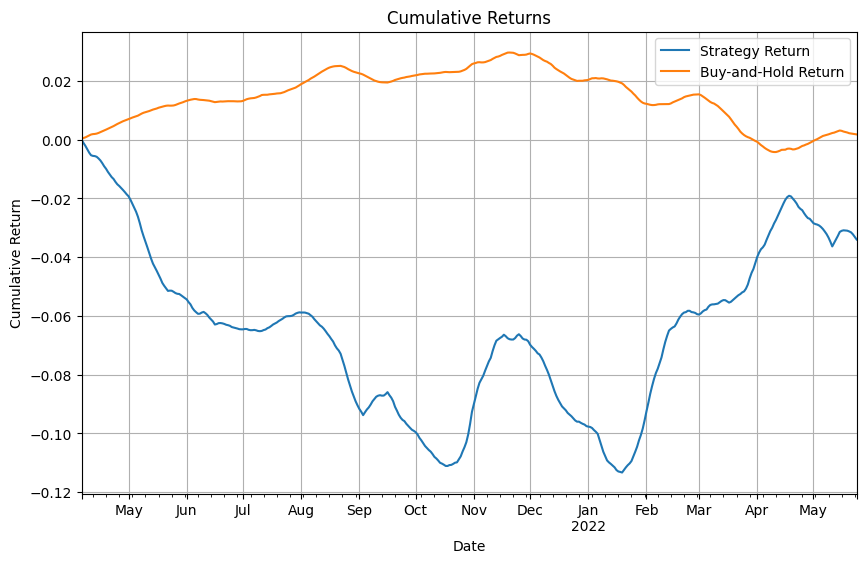


===== Debugging Outputs =====
Strategy Returns Summary:
count    414.000000
mean      -0.000083
std        0.001196
min       -0.002576
25%       -0.000871
50%       -0.000249
75%        0.000516
max        0.004570
Name: Strat_ret, dtype: float64

Actual Returns Summary:
Asset1_Actual Summary:
count    414.000000
mean      -0.000017
std        0.000558
min       -0.001486
25%       -0.000422
50%        0.000078
75%        0.000345
max        0.001323
Name: Asset1_Actual, dtype: float64
Asset2_Actual Summary:
count    414.000000
mean      -0.000154
std        0.000533
min       -0.001394
25%       -0.000521
50%       -0.000182
75%        0.000200
max        0.001546
Name: Asset2_Actual, dtype: float64
Asset3_Actual Summary:
count    414.000000
mean      -0.000035
std        0.000054
min       -0.000199
25%       -0.000071
50%       -0.000024
75%        0.000001
max        0.000112
Name: Asset3_Actual, dtype: float64
Asset4_Actual Summary:
count    414.000000
mean       0.000009
std   

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate example dataset with 5 models predicting 5 asset classes
np.random.seed(42)  # For reproducibility
dates = pd.date_range(start="2021-04-06", periods=414)
dates = pd.date_range(start="2021-04-06", periods=414)
data = {
    "Model1_Asset1": df1_pred.flatten(),
    "Model1_Asset2": df2_pred.flatten(),
    "Model1_Asset3": df3_pred.flatten(),
    "Model1_Asset4": df4_pred.flatten(),
    "Model1_Asset5": df5_pred.flatten(),

    # Simulated actual returns
    "Asset1_Actual": df1_actual.flatten(),
    "Asset2_Actual": df2_actual.flatten(),
    "Asset3_Actual": df3_actual.flatten(),
    "Asset4_Actual": df4_actual.flatten(),
    "Asset5_Actual": df5_actual.flatten(),
}


df_prediction1 = pd.DataFrame(data, index=dates)

# Step 1: Normalize actual returns
scaling_factor = 100  # Ensure actual returns are realistic percentages
for asset in ["Asset1", "Asset2", "Asset3", "Asset4", "Asset5"]:
    df_prediction1[f"{asset}_Actual"] /= scaling_factor

# Step 2: Aggregate predictions from models for each asset class
asset_classes = ["Asset1", "Asset2", "Asset3", "Asset4", "Asset5"]
for asset in asset_classes:
    model_columns = [col for col in df_prediction1.columns if asset in col]
    df_prediction1[f"{asset}_AggPred"] = df_prediction1[model_columns].mean(axis=1)

# Normalize aggregated predictions
for asset in asset_classes:
    df_prediction1[f"{asset}_AggPred"] = (df_prediction1[f"{asset}_AggPred"] - df_prediction1[f"{asset}_AggPred"].mean()) / df_prediction1[f"{asset}_AggPred"].std()

# Step 3: Define a 25-day rebalancing strategy
rebalance_period = 25
positions = []

for i in range(0, len(df_prediction1), rebalance_period):
    # Get predictions for the rebalancing window
    window = df_prediction1.iloc[i:i + rebalance_period]
    # Rank asset classes by aggregated predictions
    aggregated_predictions = {asset: window[f"{asset}_AggPred"].mean() for asset in asset_classes}
    ranked_assets = sorted(aggregated_predictions.items(), key=lambda x: x[1], reverse=True)

    # Determine long and short positions
    long_assets = [ranked_assets[j][0] for j in range(2)]  # Top 2 assets
    short_assets = [ranked_assets[j][0] for j in range(-2, 0)]  # Bottom 2 assets

    # Assign positions for the window
    for day in range(len(window)):
        position = {asset: 1 if asset in long_assets else (-1 if asset in short_assets else 0) for asset in asset_classes}
        positions.append(position)

# Step 4: Add positions to the DataFrame
positions_df = pd.DataFrame(positions, index=df_prediction1.index[:len(positions)])
for asset in asset_classes:
    df_prediction1[f"{asset}_Position"] = positions_df[asset]

# Step 5: Calculate strategy returns
df_prediction1["Strat_ret"] = 0
for asset in asset_classes:
    df_prediction1["Strat_ret"] += (
        df_prediction1[f"{asset}_Position"].shift(1).fillna(0) * df_prediction1[f"{asset}_Actual"]
    )

# Step 6: Calculate cumulative returns
df_prediction1["CumRet"] = (1 + df_prediction1["Strat_ret"]).cumprod() - 1
df_prediction1["bhRet"] = (1 + df_prediction1[["Asset1_Actual", "Asset2_Actual", "Asset3_Actual", "Asset4_Actual", "Asset5_Actual"]].mean(axis=1)).cumprod() - 1

# Step 7: Plot cumulative returns
plt.figure(figsize=(10, 6))
ax = plt.gca()
df_prediction1.plot(y="CumRet", label="Strategy Return", ax=ax)
df_prediction1.plot(y="bhRet", label="Buy-and-Hold Return", ax=ax)
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()

# Step 8: Debugging Outputs
print("\n===== Debugging Outputs =====")
print("Strategy Returns Summary:")
print(df_prediction1["Strat_ret"].describe())

print("\nActual Returns Summary:")
for asset in asset_classes:
    print(f"{asset}_Actual Summary:")
    print(df_prediction1[f"{asset}_Actual"].describe())

print("\nAggregated Predictions Summary:")
for asset in asset_classes:
    print(f"{asset}_AggPred Summary:")
    print(df_prediction1[f"{asset}_AggPred"].describe())


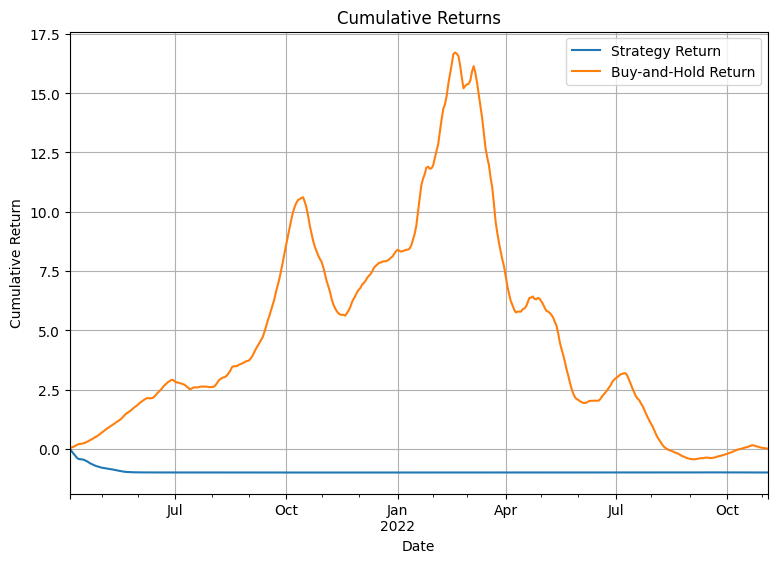


===== Debugging Outputs =====
Strategy Returns Summary:
count    414.000000
mean      -0.008281
std        0.119638
min       -0.257634
25%       -0.087080
50%       -0.024868
75%        0.051563
max        0.457011
Name: Strat_ret, dtype: float64

Actual Returns Summary:
Asset1_Actual Summary:
count    414.000000
mean      -0.001744
std        0.055836
min       -0.148578
25%       -0.042159
50%        0.007755
75%        0.034521
max        0.132254
Name: Asset1_Actual, dtype: float64
Asset2_Actual Summary:
count    414.000000
mean      -0.015412
std        0.053331
min       -0.139385
25%       -0.052149
50%       -0.018177
75%        0.019964
max        0.154588
Name: Asset2_Actual, dtype: float64
Asset3_Actual Summary:
count    414.000000
mean      -0.003538
std        0.005396
min       -0.019946
25%       -0.007060
50%       -0.002382
75%        0.000119
max        0.011165
Name: Asset3_Actual, dtype: float64
Asset4_Actual Summary:
count    414.000000
mean       0.000886
std   

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Generate example dataset with single model predictions for 5 asset classes
np.random.seed(42)  # For reproducibility
dates = pd.bdate_range(start="2021-04-06", periods=414)
data = {
    "Model1_Asset1": df1_pred.flatten(),
    "Model1_Asset2": df2_pred.flatten(),
    "Model1_Asset3": df3_pred.flatten(),
    "Model1_Asset4": df4_pred.flatten(),
    "Model1_Asset5": df5_pred.flatten(),

    # Simulated actual returns
    "Asset1_Actual": df1_actual.flatten(),
    "Asset2_Actual": df2_actual.flatten(),
    "Asset3_Actual": df3_actual.flatten(),
    "Asset4_Actual": df4_actual.flatten(),
    "Asset5_Actual": df5_actual.flatten(),
}

df_prediction1 = pd.DataFrame(data, index=dates)

# Step 1: Normalize actual returns (if required)
# Since the actual returns are already realistic (as decimals), no scaling is applied here.
# Remove unnecessary division by scaling factor.

# Step 2: Normalize single model predictions for each asset
asset_classes = ["Asset1", "Asset2", "Asset3", "Asset4", "Asset5"]
for asset in asset_classes:
    # Normalize each model's predictions
    df_prediction1[f"{asset}_NormPred"] = (
        df_prediction1[f"Model1_{asset}"] - df_prediction1[f"Model1_{asset}"].mean()
    ) / df_prediction1[f"Model1_{asset}"].std()

# Step 3: Define a 25-day rebalancing strategy
rebalance_period = 25
positions = []

for i in range(0, len(df_prediction1), rebalance_period):
    # Get predictions for the rebalancing window
    window = df_prediction1.iloc[i:i + rebalance_period]
    # Rank asset classes by normalized predictions
    aggregated_predictions = {asset: window[f"{asset}_NormPred"].mean() for asset in asset_classes}
    ranked_assets = sorted(aggregated_predictions.items(), key=lambda x: x[1], reverse=True)

    # Determine long and short positions
    long_assets = [ranked_assets[j][0] for j in range(2)]  # Top 2 assets
    short_assets = [ranked_assets[j][0] for j in range(-2, 0)]  # Bottom 2 assets

    # Assign positions for the window
    for day in range(len(window)):
        position = {asset: 1 if asset in long_assets else (-1 if asset in short_assets else 0) for asset in asset_classes}
        positions.append(position)

# Step 4: Add positions to the DataFrame
positions_df = pd.DataFrame(positions, index=df_prediction1.index[:len(positions)])
for asset in asset_classes:
    df_prediction1[f"{asset}_Position"] = positions_df[asset]

# Step 5: Calculate strategy returns
df_prediction1["Strat_ret"] = 0
for asset in asset_classes:
    df_prediction1["Strat_ret"] += (
        df_prediction1[f"{asset}_Position"].shift(1).fillna(0) * df_prediction1[f"{asset}_Actual"]
    )

# Step 6: Calculate cumulative returns
df_prediction1["CumRet"] = (1 + df_prediction1["Strat_ret"]).cumprod() - 1
df_prediction1["bhRet"] = (1 + df_prediction1[["Asset1_Actual", "Asset2_Actual", "Asset3_Actual", "Asset4_Actual", "Asset5_Actual"]].mean(axis=1)).cumprod() - 1

# Step 7: Plot cumulative returns
plt.figure(figsize=(9, 6))
ax = plt.gca()
df_prediction1.plot(y="CumRet", label="Strategy Return", ax=ax)
df_prediction1.plot(y="bhRet", label="Buy-and-Hold Return", ax=ax)
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()

# Step 8: Debugging Outputs
print("\n===== Debugging Outputs =====")
print("Strategy Returns Summary:")
print(df_prediction1["Strat_ret"].describe())

print("\nActual Returns Summary:")
for asset in asset_classes:
    print(f"{asset}_Actual Summary:")
    print(df_prediction1[f"{asset}_Actual"].describe())

print("\nNormalized Predictions Summary:")
for asset in asset_classes:
    print(f"{asset}_NormPred Summary:")
    print(df_prediction1[f"{asset}_NormPred"].describe())


In [76]:
for asset in asset_classes:
    correlation = df_prediction1[f"{asset}_NormPred"].corr(df_prediction1[f"{asset}_Actual"])
    print(f"Correlation between {asset}_NormPred and {asset}_Actual: {correlation:.2f}")


Correlation between Asset1_NormPred and Asset1_Actual: 0.12
Correlation between Asset2_NormPred and Asset2_Actual: 0.10
Correlation between Asset3_NormPred and Asset3_Actual: -0.09
Correlation between Asset4_NormPred and Asset4_Actual: 0.10
Correlation between Asset5_NormPred and Asset5_Actual: -0.13


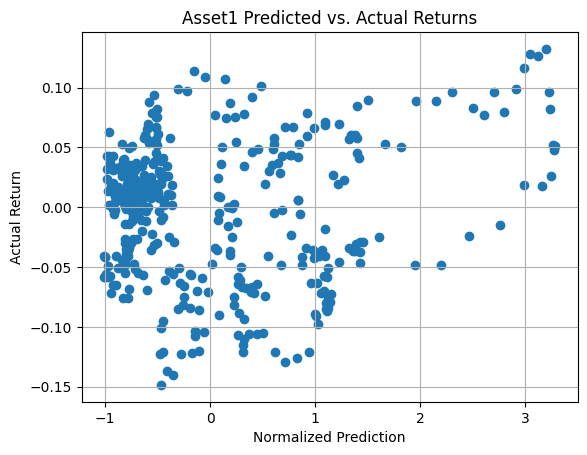

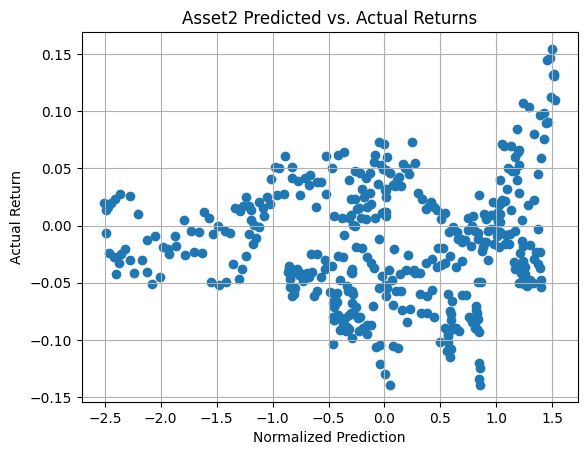

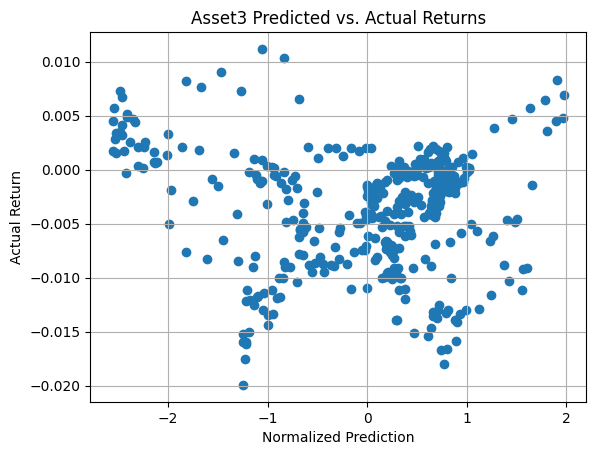

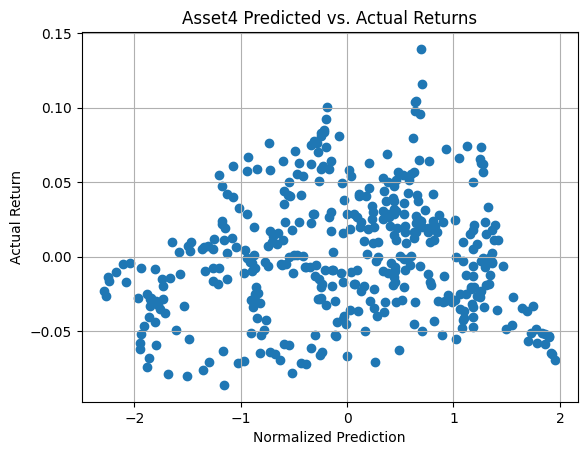

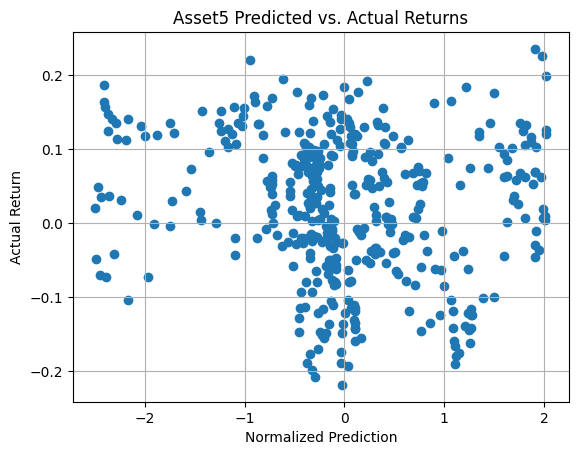

In [77]:
for asset in asset_classes:
    plt.scatter(df_prediction1[f"{asset}_NormPred"], df_prediction1[f"{asset}_Actual"])
    plt.title(f"{asset} Predicted vs. Actual Returns")
    plt.xlabel("Normalized Prediction")
    plt.ylabel("Actual Return")
    plt.grid(True)
    plt.show()


## Step 3

So, In this step we will also build a DL models but this time of multi-output, here how we are going to do :

We will first build a DL model with multi-ouptut that uses LSTM network architecture that blends together all of the information from the
5 models of Step 2, to predict the 25-day ahead return of each ETF.

After that we will Train the single model with 5 ouptuts and do an in sample predective performance and also Test each of the model out of sample and compare the results of both across the assets.

Then we will a trading strategy that uses the out-of-sample predection of all the different models and the backtest it check our predective performance.

### model description :

Here is the model description for multi-ouput model description, here we are going to use Multi-output Bidirectional LSTM architecture, here how the workflow goes :

* First we will prepare the data, we will concatenate all the ETF data together in single dataset.

* Then we will prepare the data for input by doing the same feature engineering in which we will calculate 1-day, 10-days, and 50-days cumulative returns of all the ETF at one go to predict the 25-day ahead return.

* After that we will define our data into feature, train, test and validation set, also we will also have an window i.e sequence length of 30 as we are using LSTM architecture.

* In the next step we will we will scale the different variables under the min max scalar to ease our computation then finally we will split the data in train and test split.

* Now Finally we will define our LSTM model architecture, This time we are going to do things little bit differently we are going to use bidirectional LSTM model for our predection, here's how our model work :

> This time also our model architecture consists of a LSTM model designed for a regression task, predicting continuous values for 5 different ETFs. It begins with four Bidirectional LSTM layers, each containing 50 units and utilizing the same tanh activation function, with L2 regularization (L2=0.01) applied to the kernel weights to prevent overfitting. The first three Bidirectional LSTM layers return sequences, allowing the propagation of sequential information through the network, while the fourth Bidirectional LSTM layer does not return sequences, outputting only the final hidden state. Each Bidirectional LSTM layer is followed by a Dropout layer with a dropout rate of 0.2, ensuring robustness and generalization. After the LSTM layers, the model includes two Dense layers with 20 and 10 units respectively, both using ReLU activation, followed by Dropout layers. The network finishes with an output layer comprising 5 neurons with a linear activation function, suitable for regression predictions. The model is compiled with the Adam optimizer, using a learning rate of 1e-4, and the loss function is mean squared error (MSE). Early stopping is employed to monitor the validation loss, with a patience of 5 epochs and the ability to restore the best-performing weights.

* After that we will define the final features (learning rate, loss function, early stopping criteria, batch size, ...) and train the model, and after training we need to do the job of testing and to find how our model is performing we will do and final features (learning rate, loss function, early stopping criteria, batch size, ...) and train the model, and to check the perfomance of our model we will do an out of sample predection using the standard out-of-sample R-squared measured and check the results.

In [78]:
df

Ticker        Date       SPY       TLT       SHY       GLD       DBO
0       2018-01-03  0.006305  0.004770  0.000000 -0.002640  0.021360
1       2018-01-04  0.004206 -0.000159 -0.000477  0.005114  0.001919
2       2018-01-05  0.006642 -0.002860  0.000000 -0.001037 -0.004805
3       2018-01-08  0.001827 -0.000637  0.000000 -0.000160  0.005764
4       2018-01-09  0.002261 -0.013463 -0.000358 -0.004639  0.017094
...            ...       ...       ...       ...       ...       ...
1252    2022-12-22 -0.014369 -0.000193 -0.000614 -0.012159 -0.007486
1253    2022-12-23  0.005736 -0.014769 -0.000492  0.002994  0.024293
1254    2022-12-27 -0.003951 -0.019971 -0.001354  0.008395  0.007307
1255    2022-12-28 -0.012506 -0.005909  0.000000 -0.004516 -0.010645
1256    2022-12-29  0.017840  0.011287  0.000739  0.005583 -0.004693

[1257 rows x 6 columns]

In [79]:
etfs = ['SPY', 'TLT', 'SHY', 'GLD', 'DBO']

# Create an empty list to store processed DataFrames
processed_etfs = []

for etf in etfs:
    df_etf = df[['Date', etf]].copy()
    df_etf[f"Ret_10_{etf}"] = df_etf[etf].rolling(10).apply(lambda x: np.exp(np.sum(x)) - 1)
    df_etf[f"Ret_50_{etf}"] = df_etf[etf].rolling(50).apply(lambda x: np.exp(np.sum(x)) - 1)
    df_etf[f"Ret25_{etf}"] = df_etf[etf].rolling(25).apply(lambda x: np.exp(np.sum(x)) - 1).shift(-25)

    del df_etf[etf]  # Remove the original ETF column to keep only features
    processed_etfs.append(df_etf)

# Merge all processed DataFrames
df_combined = pd.concat(processed_etfs, axis=1)

# Drop rows with NaNs introduced by rolling and shifting
df_combined = df_combined.dropna()



In [80]:
df_combined.head()

Ticker        Date  Ret_10_SPY  Ret_50_SPY  Ret25_SPY        Date  Ret_10_TLT  \
49      2018-03-15    0.027269    0.023180  -0.030509  2018-03-15    0.007710   
50      2018-03-16    0.019028    0.013791  -0.027826  2018-03-16    0.012336   
51      2018-03-19   -0.006246   -0.004124  -0.027764  2018-03-19    0.011861   
52      2018-03-20   -0.007073   -0.009034  -0.027016  2018-03-20    0.006856   
53      2018-03-21   -0.008615   -0.012741  -0.015235  2018-03-21    0.009067   

Ticker  Ret_50_TLT  Ret25_TLT        Date  Ret_10_SHY  Ret_50_SHY  Ret25_SHY  \
49       -0.041836  -0.014804  2018-03-15    -0.00024   -0.004414  -0.002277   
50       -0.049806  -0.011017  2018-03-16    -0.00024   -0.004891  -0.001918   
51       -0.052669  -0.012392  2018-03-19    -0.00024   -0.004416  -0.001679   
52       -0.053775  -0.015048  2018-03-20    -0.00036   -0.004774  -0.001439   
53       -0.052137  -0.009237  2018-03-21     0.00036   -0.004058  -0.001918   

Ticker        Date  Ret_10_GLD  Ret_50_GLD  Ret25_GLD        Date  Ret_10_DBO  \
49      2018-03-15    0.001443   -0.001998   0.013851  2018-03-15    0.016206   
50      2018-03-16   -0.006300   -0.001763   0.008186  2018-03-16    0.023719   
51      2018-03-19   -0.002476   -0.004703   0.010891  2018-03-19    0.006567   
52      2018-03-20   -0.017545   -0.008139   0.008849  2018-03-20    0.020619   
53      2018-03-21    0.006045    0.009337  -0.011939  2018-03-21    0.062738   

Ticker  Ret_50_DBO  Ret25_DBO  
49        0.046124   0.098499  
50        0.036503   0.096386  
51        0.028763   0.086673  
52        0.049133   0.076217  
53        0.070881   0.054562

In [81]:
# Separate features and targets
feature_columns = [col for col in df_combined.columns if "Ret25" not in col and col != 'Date']
target_columns = [col for col in df_combined.columns if "Ret25" in col]

X = df_combined[feature_columns].values.astype("float32")
y = df_combined[target_columns].values.astype("float32")

# Print shapes to verify
print("Features shape:", X.shape)
print("Targets shape:", y.shape)


Features shape: (1183, 10)
Targets shape: (1183, 5)


In [82]:
val_split = 0.2
train_split = 0.70
train_size = int(len(df_combined) * train_split)
val_size = int(train_size * val_split)
test_size = int(len(df_combined) - train_size)

window_size = 30

ts = test_size
split_time = len(df_combined) - ts
test_time = df_combined.iloc[split_time + window_size :, 0:1].values


y_train_set = y[:split_time]
y_test_set = y[split_time:]

X_train_set = X[:split_time]
X_test_set = X[split_time:]

n_features = X_train_set.shape[1]

In [83]:
scaler_input = MinMaxScaler(feature_range=(-1, 1))
scaler_input.fit(X_train_set)
X_train_set_scaled = scaler_input.transform(X_train_set)
X_test_set_scaled = scaler_input.transform(X_test_set)

mean_ret = np.mean(y_train_set)

scaler_output = MinMaxScaler(feature_range=(-1, 1))
y_train_set_scaled = scaler_output.fit_transform(y_train_set)
y_test_set_scaled = scaler_output.transform(y_test_set)

In [84]:
# Prepare training data with sliding windows (for scaled targets)
X_train = []
y_train = []

for i in range(window_size, len(X_train_set_scaled)):
    # Features: Last 'window_size' observations
    X_train.append(X_train_set_scaled[i - window_size:i, :])
    # Targets: Scaled multi-output targets for the next time step
    y_train.append(y_train_set_scaled[i])

X_train, y_train = np.array(X_train), np.array(y_train)

# Prepare test data with sliding windows (for scaled targets)
X_test = []
y_test = []

for i in range(window_size, len(X_test_set_scaled)):
    # Features: Last 'window_size' observations
    X_test.append(X_test_set_scaled[i - window_size:i, :])
    # Targets: Scaled multi-output targets for the next time step
    y_test.append(y_test_set_scaled[i])

X_test, y_test = np.array(X_test), np.array(y_test)

# Verify shapes
print("Training data shapes -> X_train:", X_train.shape, ", y_train:", y_train.shape)
print("Test data shapes -> X_test:", X_test.shape, ", y_test:", y_test.shape)

Training data shapes -> X_train: (798, 30, 10) , y_train: (798, 5)
Test data shapes -> X_test: (325, 30, 10) , y_test: (325, 5)


In [85]:
# Set the random seed for reproducibility
SEED = 4321
units_lstm = 50
n_dropout = 0.2
act_fun = "relu"
n_outputs = 5  # Number of outputs (one for each ETF)

# Build the model
model = Sequential()

# Bidirectional LSTM layers with regularization
model.add(
    Bidirectional(
        LSTM(
            units=units_lstm,
            return_sequences=True,
            activation="tanh",
            input_shape=(X_train.shape[1], X_train.shape[2]),
            kernel_regularizer=l2(0.01),
        )
    )
)
model.add(
    Bidirectional(
        LSTM(
            units=units_lstm,
            return_sequences=True,
            activation="tanh",
            kernel_regularizer=l2(0.01),
        )
    )
)
model.add(Dropout(n_dropout, seed=SEED))

model.add(
    Bidirectional(
        LSTM(
            units=units_lstm,
            return_sequences=True,
            activation="tanh",
            kernel_regularizer=l2(0.01),
        )
    )
)
model.add(Dropout(n_dropout, seed=SEED))

model.add(
    Bidirectional(
        LSTM(
            units=units_lstm,
            return_sequences=True,
            activation="tanh",
            kernel_regularizer=l2(0.01),
        )
    )
)
model.add(Dropout(n_dropout, seed=SEED))

model.add(
    Bidirectional(
        LSTM(
            units=units_lstm,
            return_sequences=False,
            activation="tanh",
            kernel_regularizer=l2(0.01),
        )
    )
)
model.add(Dropout(n_dropout, seed=SEED))

# Dense layers to reduce dimensionality before output
model.add(Dense(units=20, activation=act_fun))
model.add(Dropout(n_dropout, seed=SEED))

model.add(Dense(units=10, activation=act_fun))
model.add(Dropout(n_dropout, seed=SEED))

# Output layer with 5 units (one for each ETF)
model.add(Dense(units=n_outputs, activation="linear"))

# Compile the model
hp_lr = 1e-4  # Learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=hp_lr), loss="mean_squared_error"
)

# Early stopping callback
es = EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=5, restore_best_weights=True
)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [86]:
# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=64,
    validation_split=val_split,
    callbacks=[es],
    verbose=2
)

# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")

Epoch 1/100
10/10 - 11s - 1s/step - loss: 11.1294 - val_loss: 11.0456
Epoch 2/100
10/10 - 0s - 30ms/step - loss: 10.8948 - val_loss: 10.8087
Epoch 3/100
10/10 - 0s - 29ms/step - loss: 10.6643 - val_loss: 10.5715
Epoch 4/100
10/10 - 0s - 33ms/step - loss: 10.4388 - val_loss: 10.3406
Epoch 5/100
10/10 - 0s - 31ms/step - loss: 10.2165 - val_loss: 10.1165
Epoch 6/100
10/10 - 0s - 30ms/step - loss: 10.0010 - val_loss: 9.8995
Epoch 7/100
10/10 - 0s - 29ms/step - loss: 9.7902 - val_loss: 9.6891
Epoch 8/100
10/10 - 0s - 30ms/step - loss: 9.5817 - val_loss: 9.4815
Epoch 9/100
10/10 - 0s - 30ms/step - loss: 9.3768 - val_loss: 9.2794
Epoch 10/100
10/10 - 0s - 29ms/step - loss: 9.1788 - val_loss: 9.0819
Epoch 11/100
10/10 - 0s - 42ms/step - loss: 8.9861 - val_loss: 8.8923
Epoch 12/100
10/10 - 0s - 42ms/step - loss: 8.7964 - val_loss: 8.7053
Epoch 13/100
10/10 - 0s - 40ms/step - loss: 8.6113 - val_loss: 8.5228
Epoch 14/100
10/10 - 0s - 44ms/step - loss: 8.4311 - val_loss: 8.3443
Epoch 15/100
10/10 

In [87]:
# Model summary
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 30, 100)             │          24,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 30, 100)             │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 30, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 30, 100)             │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 30, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 30, 100)             │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 30, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 100)                 │          60,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 20)                  │           2,020 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 10)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 5)                   │              55 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 804,857 (3.07 MB)

 Trainable params: 268,285 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 536,572 (2.05 MB)

In [88]:
# Predict on test data
predictions = model.predict(X_test)

# Inverse transform predictions and true values if they are scaled
predictions = scaler_output.inverse_transform(predictions)  # Shape: (num_samples, 5)
true_values = scaler_output.inverse_transform(y_test)       # Shape: (num_samples, 5)

# Compute R² for each output (ETF)
def R2_campbell_multi(y_true, y_pred, mean_ret):
    r2_scores = []
    for i in range(y_true.shape[1]):  # Iterate over each ETF
        y_test_i = y_true[:, i]
        y_pred_i = y_pred[:, i]
        sse = sum((y_test_i - y_pred_i) ** 2)  # Sum of squared errors
        tse = sum((y_test_i - mean_ret[i]) ** 2)  # Total sum of squares
        r2_score = 1 - (sse / tse)
        r2_scores.append(r2_score)
    return r2_scores

# Compute mean return for each ETF (for the R² calculation)
mean_ret_multi = np.mean(true_values, axis=0)

# Compute R² scores
r2_scores = R2_campbell_multi(true_values, predictions, mean_ret_multi)
for i, r2 in enumerate(r2_scores):
    print(f"Out-of-sample R-squared for ETF {i + 1}: {r2}")



11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
Out-of-sample R-squared for ETF 1: -0.264696308032323
Out-of-sample R-squared for ETF 2: -0.39265593732273096
Out-of-sample R-squared for ETF 3: -1.155273637298654
Out-of-sample R-squared for ETF 4: 0.037505848765581495
Out-of-sample R-squared for ETF 5: -0.6893508460948767


In [89]:
# Optional: Create a DataFrame for visualization
df_predictions2 = pd.DataFrame(
    {
        "Date": test_time.flatten(),  # Ensure this is aligned with your test set
        "ETF_1_Pred": predictions[:, 0],
        "ETF_1_True": true_values[:, 0],
        "ETF_2_Pred": predictions[:, 1],
        "ETF_2_True": true_values[:, 1],
        "ETF_3_Pred": predictions[:, 2],
        "ETF_3_True": true_values[:, 2],
        "ETF_4_Pred": predictions[:, 3],
        "ETF_4_True": true_values[:, 3],
        "ETF_5_Pred": predictions[:, 4],
        "ETF_5_True": true_values[:, 4],
    }
)
print(df_predictions2.head())



         Date  ETF_1_Pred  ETF_1_True  ETF_2_Pred  ETF_2_True  ETF_3_Pred  \
0  2021-08-11    0.017327    0.007639    0.001673    0.023280    0.001475   
1  2021-08-12    0.016810   -0.008335    0.002105    0.020036    0.001562   
2  2021-08-13    0.016707   -0.026642    0.002184    0.016627    0.001579   
3  2021-08-16    0.016719   -0.029845    0.002165    0.013297    0.001577   
4  2021-08-17    0.017084   -0.013918    0.001847    0.019751    0.001515   

   ETF_3_True  ETF_4_Pred  ETF_4_True  ETF_5_Pred  ETF_5_True  
0    0.000232    0.009400    0.000183    0.020415    0.053344  
1    0.000000    0.010070   -0.001646    0.018952    0.048761  
2    0.000116    0.010216   -0.008714    0.018658    0.048622  
3    0.000116    0.010216   -0.007057    0.018688    0.057190  
4   -0.000232    0.009771   -0.009283    0.019713    0.087459  


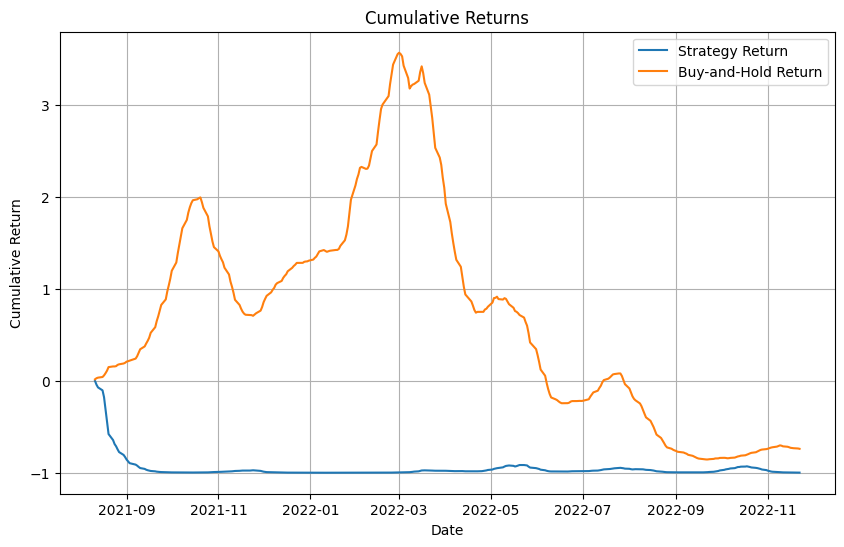


===== Debugging Outputs =====
Strategy Returns Summary:
count    325.000000
mean      -0.011963
std        0.129046
min       -0.271715
25%       -0.116313
50%       -0.021736
75%        0.076067
max        0.317077
Name: Strat_ret, dtype: float64

Buy-and-Hold Returns Summary:
count    325.000000
mean       0.689635
std        1.187499
min       -0.855609
25%       -0.224296
50%        0.719548
75%        1.404324
max        3.571723
Name: bhRet, dtype: float64

ETF Predictions and True Values Correlation:
Correlation between ETF_1_Pred and ETF_1_True: 0.00
Correlation between ETF_2_Pred and ETF_2_True: -0.19
Correlation between ETF_3_Pred and ETF_3_True: -0.20
Correlation between ETF_4_Pred and ETF_4_True: 0.22
Correlation between ETF_5_Pred and ETF_5_True: -0.51


In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Create DataFrame from the given data
df_predictions2 = pd.DataFrame(
    {
        "Date": test_time.flatten(),  # Ensure this matches your test set timeline
        "ETF_1_Pred": predictions[:, 0],
        "ETF_1_True": true_values[:, 0],
        "ETF_2_Pred": predictions[:, 1],
        "ETF_2_True": true_values[:, 1],
        "ETF_3_Pred": predictions[:, 2],
        "ETF_3_True": true_values[:, 2],
        "ETF_4_Pred": predictions[:, 3],
        "ETF_4_True": true_values[:, 3],
        "ETF_5_Pred": predictions[:, 4],
        "ETF_5_True": true_values[:, 4],
    }
)

# Step 2: Normalize Predictions (if required)
for i in range(1, 6):  # ETFs 1 to 5
    df_predictions2[f"ETF_{i}_NormPred"] = (
        df_predictions2[f"ETF_{i}_Pred"] - df_predictions2[f"ETF_{i}_Pred"].mean()
    ) / df_predictions2[f"ETF_{i}_Pred"].std()

# Step 3: Define a 25-day rebalancing strategy
rebalance_period = 25
positions = []

etfs = ["ETF_1", "ETF_2", "ETF_3", "ETF_4", "ETF_5"]
for i in range(0, len(df_predictions2), rebalance_period):
    # Select predictions for the rebalancing window
    window = df_predictions2.iloc[i:i + rebalance_period]

    # Calculate average normalized predictions per ETF over the window
    aggregated_predictions = {etf: window[f"{etf}_NormPred"].mean() for etf in etfs}

    # Rank ETFs based on predictions
    ranked_etfs = sorted(aggregated_predictions.items(), key=lambda x: x[1], reverse=True)

    # Determine long and short positions
    long_etfs = [ranked_etfs[j][0] for j in range(2)]  # Top 2 ETFs
    short_etfs = [ranked_etfs[j][0] for j in range(-2, 0)]  # Bottom 2 ETFs

    # Assign positions for the window
    for day in range(len(window)):
        position = {etf: 1 if etf in long_etfs else (-1 if etf in short_etfs else 0) for etf in etfs}
        positions.append(position)

# Step 4: Add positions to the DataFrame
positions_df = pd.DataFrame(positions, index=df_predictions2.index[:len(positions)])
for etf in etfs:
    df_predictions2[f"{etf}_Position"] = positions_df[etf]

# Step 5: Calculate strategy returns
df_predictions2["Strat_ret"] = 0
for etf in etfs:
    df_predictions2["Strat_ret"] += (
        df_predictions2[f"{etf}_Position"].shift(1).fillna(0) * df_predictions2[f"{etf}_True"]
    )

# Step 6: Calculate cumulative returns
df_predictions2["CumRet"] = (1 + df_predictions2["Strat_ret"]).cumprod() - 1
df_predictions2["bhRet"] = (1 + df_predictions2[[f"{etf}_True" for etf in etfs]].mean(axis=1)).cumprod() - 1

# Step 7: Plot cumulative returns
plt.figure(figsize=(10, 6))
ax = plt.gca()
df_predictions2.plot(x="Date", y="CumRet", label="Strategy Return", ax=ax)
df_predictions2.plot(x="Date", y="bhRet", label="Buy-and-Hold Return", ax=ax)
plt.title("Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.show()

# Step 8: Debugging Outputs
print("\n===== Debugging Outputs =====")
print("Strategy Returns Summary:")
print(df_predictions2["Strat_ret"].describe())

print("\nBuy-and-Hold Returns Summary:")
print(df_predictions2["bhRet"].describe())

print("\nETF Predictions and True Values Correlation:")
for etf in etfs:
    correlation = df_predictions2[f"{etf}_Pred"].corr(df_predictions2[f"{etf}_True"])
    print(f"Correlation between {etf}_Pred and {etf}_True: {correlation:.2f}")


In [91]:
df_predictions2.head()

Date  ETF_1_Pred  ETF_1_True  ETF_2_Pred  ETF_2_True  ETF_3_Pred  \
0  2021-08-11    0.017327    0.007639    0.001673    0.023280    0.001475   
1  2021-08-12    0.016810   -0.008335    0.002105    0.020036    0.001562   
2  2021-08-13    0.016707   -0.026642    0.002184    0.016627    0.001579   
3  2021-08-16    0.016719   -0.029845    0.002165    0.013297    0.001577   
4  2021-08-17    0.017084   -0.013918    0.001847    0.019751    0.001515   

   ETF_3_True  ETF_4_Pred  ETF_4_True  ETF_5_Pred  ...  ETF_4_NormPred  \
0    0.000232    0.009400    0.000183    0.020415  ...        0.480310   
1    0.000000    0.010070   -0.001646    0.018952  ...        0.539724   
2    0.000116    0.010216   -0.008714    0.018658  ...        0.552714   
3    0.000116    0.010216   -0.007057    0.018688  ...        0.552725   
4   -0.000232    0.009771   -0.009283    0.019713  ...        0.513264   

   ETF_5_NormPred  ETF_1_Position  ETF_2_Position  ETF_3_Position  \
0       -0.105556              -1               0               1   
1       -0.136041              -1               0               1   
2       -0.142162              -1               0               1   
3       -0.141525              -1               0               1   
4       -0.120177              -1               0               1   

   ETF_4_Position  ETF_5_Position  Strat_ret    CumRet     bhRet  
0               1              -1   0.000000  0.000000  0.016935  
1               1              -1  -0.042072 -0.042072  0.028898  
2               1              -1  -0.030579 -0.071364  0.035073  
3               1              -1  -0.034285 -0.103203  0.042050  
4               1              -1  -0.083056 -0.177687  0.059510  

[5 rows x 24 columns]